In [52]:
import pandas as pd
import re
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data Intro

 (From Kaggle, see https://www.kaggle.com/datasets/cnic92/200-financial-indicators-of-us-stocks-20142018?select=2018_Financial_Data.csv)

There are in total 5 datasets: `2014_Financial_Data.csv`, `2015_Financial_Data.csv`, `2016_Financial_Data.csv`, `2017_Financial_Data.csv`, `2018_Financial_Data.csv`.

Each dataset contains 200+ financial indicators, that are commonly found in the 10-K filings each publicly traded company releases yearly, for a plethora of US stocks (on average, 4k stocks are listed in each dataset). 

The dataset was built by the author leveraging Financial Modeling Prep API and pandas_datareader.

### Important Remarks Regarding the Datasets
1. Some financial indicator values are missing (`nan` cells), so the user can select the best technique to clean each dataset (`dropna`, `fillna`, etc.).
2. There are outliers, meaning extreme values that are probably caused by mistypings. Also in this case, the user can choose how to clean each dataset (have a look at the 1% - 99% percentile values).
3. The third-to-last column, `Sector`, lists the sector of each stock. Indeed, in the US stock market each company is part of a sector that classifies it in a macro-area. Since all the sectors have been collected (Basic Materials, Communication Services, Consumer Cyclical, Consumer Defensive, Energy, Financial Services, Healthcare, Industrial, Real Estate, Technology and Utilities), the user has the option to perform per-sector analyses and comparisons.
4. The second-to-last column, `PRICE VAR [%]`, lists the percent price variation of each stock for the year. For example, if we consider the dataset `2015_Financial_Data.csv`, we will have:
    - 200+ financial indicators for the year 2015;
    - percent price variation for the year 2016 (meaning from the first trading day on Jan 2016 to the last trading day on Dec 2016).

5. The last column, `class`, lists a binary classification for each stock, where
    - for each stock, if the `PRICE VAR [%]` value is positive, `class = 1`. From a trading perspective, the `1` identifies those stocks that an hypothetical trader should **BUY** at the start of the year and sell at the end of the year for a profit.
    - for each stock, if the `PRICE VAR [%]` value is negative, `class = 0`. From a trading perspective, the `0` identifies those stocks that an hypothetical trader should **NOT BUY**, since their value will decrease, meaning a loss of capital.

The columns `PRICE VAR [%]` and `class` make possible to use the datasets for both classification and regression tasks:
- If the we wish to train a machine learning model so that it learns to classify those stocks that in buy-worthy and not buy-worthy, it is possible to get the targets from the class column;
- If the we wish to train a machine learning model so that it learns to predict the future value of a stock, it is possible to get the targets from the `PRICE VAR [%]` column.

# Basic Processing

In [2]:
# Load raw data
df2014 = pd.read_csv('data/2014_Financial_Data.csv')
df2015 = pd.read_csv('data/2015_Financial_Data.csv')
df2016 = pd.read_csv('data/2016_Financial_Data.csv')
df2017 = pd.read_csv('data/2017_Financial_Data.csv')
df2018 = pd.read_csv('data/2018_Financial_Data.csv')

In [3]:
# Inspect how does it look like -- The "Unnamed: 0" column is probably stock ticker
df2014.head()

Unnamed: 0       Revenue  Revenue Growth  Cost of Revenue  Gross Profit  \
0         PG  7.440100e+10         -0.0713     3.903000e+10  3.537100e+10   
1       VIPS  3.734148e+09          1.1737     2.805625e+09  9.285226e+08   
2         KR  9.837500e+10          0.0182     7.813800e+10  2.023700e+10   
3        RAD  2.552641e+10          0.0053     1.820268e+10  7.323734e+09   
4        GIS  1.790960e+10          0.0076     1.153980e+10  6.369800e+09   

   R&D Expenses  SG&A Expense  Operating Expenses  Operating Income  \
0  0.000000e+00  2.146100e+10        2.146100e+10      1.391000e+10   
1  1.083303e+08  3.441414e+08        7.939267e+08      1.345959e+08   
2  0.000000e+00  1.519600e+10        1.751200e+10      2.725000e+09   
3  0.000000e+00  6.561162e+09        6.586482e+09      7.372520e+08   
4  0.000000e+00  3.474300e+09        3.412400e+09      2.957400e+09   

   Interest Expense  Earnings before Tax  Income Tax Expense  \
0      7.090000e+08         1.449400e+10        2.851000e+09   
1      1.214869e+07         1.753823e+08        3.955957e+07   
2      4.430000e+08         2.270000e+09        7.510000e+08   
3      4.245910e+08         2.502180e+08        8.040000e+05   
4      3.024000e+08         2.707700e+09        8.833000e+08   

   Net Income - Non-Controlling int  Net Income - Discontinued ops  \
0                      1.420000e+08                  -1.127000e+09   
1                     -1.431918e+07                   0.000000e+00   
2                      1.200000e+07                   0.000000e+00   
3                      0.000000e+00                   0.000000e+00   
4                      3.690000e+07                   0.000000e+00   

     Net Income  Preferred Dividends  Net Income Com     EPS  EPS Diluted  \
0  1.164300e+10                  0.0    1.164300e+10  4.1900        4.010   
1  1.358227e+08                  0.0    1.358227e+08  0.2396        0.226   
2  1.519000e+09                  0.0    1.519000e+09  1.4700        1.450   
3  2.494140e+08           33998000.0    2.154160e+08  4.6000        4.600   
4  1.824400e+09                  0.0    1.824400e+09  2.9000        2.830   

   Weighted Average Shs Out  Weighted Average Shs Out (Dil)  \
0              2.705960e+09                    2.705960e+09   
1                       NaN                    1.829362e+07   
2              1.033053e+09                    1.028000e+09   
3              4.832628e+07                    4.832628e+07   
4              6.144922e+08                    6.144922e+08   

   Dividend per Share  Gross Margin  EBITDA Margin  EBIT Margin  \
0               2.448        0.4754         0.2470       0.2043   
1               0.000        0.2487         0.0107       0.0502   
2               0.307        0.2057         0.0450       0.0276   
3               0.000        0.2869         0.0420       0.0264   
4               1.550        0.3557         0.2010       0.1681   

   Profit Margin  Free Cash Flow margin        EBITDA          EBIT  \
0         0.1560                 0.1359  1.834400e+10  1.520300e+10   
1         0.0058                 0.0704  2.456858e+08  1.875310e+08   
2         0.0150                 0.0126  4.416000e+09  2.713000e+09   
3         0.0080                 0.0144  1.078550e+09  6.748090e+08   
4         0.1020                 0.1052  3.595500e+09  3.010100e+09   

   Consolidated Income  Earnings Before Tax Margin  Net Profit Margin  \
0         1.178500e+10                      0.1948             0.1565   
1         1.215036e+08                      0.0470             0.0364   
2         1.531000e+09                      0.0231             0.0154   
3         2.494140e+08                      0.0098             0.0098   
4         1.861300e+09                      0.1512             0.1019   

   Cash and cash equivalents  Short-term investments  \
0               8.558000e+09            2.128000e+09   
1               7.735149e+08            6.083852e+08   
2               4.010000e+0

In [4]:
# Check that the df of different years all have same columns
print(df2014.columns)
print(df2015.columns)
print(df2016.columns)
print(df2017.columns)
print(df2018.columns)

Index(['Unnamed: 0', 'Revenue', 'Revenue Growth', 'Cost of Revenue',
       'Gross Profit', 'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense',
       ...
       'Receivables growth', 'Inventory Growth', 'Asset Growth',
       'Book Value per Share Growth', 'Debt Growth', 'R&D Expense Growth',
       'SG&A Expenses Growth', 'Sector', '2015 PRICE VAR [%]', 'Class'],
      dtype='object', length=225)
Index(['Unnamed: 0', 'Revenue', 'Revenue Growth', 'Cost of Revenue',
       'Gross Profit', 'R&D Expenses', 'SG&A Expense', 'Operating Expenses',
       'Operating Income', 'Interest Expense',
       ...
       'Receivables growth', 'Inventory Growth', 'Asset Growth',
       'Book Value per Share Growth', 'Debt Growth', 'R&D Expense Growth',
       'SG&A Expenses Growth', 'Sector', '2016 PRICE VAR [%]', 'Class'],
      dtype='object', length=225)
Index(['Unnamed: 0', 'Revenue', 'Revenue Growth', 'Cost of Revenue',
       'Gross Profit', 'R&D E

In [5]:
# Function to convert camel case to snake case and handle pre-existing underscores
def camel_to_snake(name):
    # Insert an underscore between lowercase followed by uppercase
    s1 = re.sub('([a-z])([A-Z])', r'\1_\2', name)
    # Handle pre-existing underscores (avoid double underscores)
    s2 = re.sub('_+', '_', s1)
    return s2.lower()

In [6]:
# Then convert any camelCase to snake_case
df2014.columns = [camel_to_snake(col) for col in df2014.columns]
df2015.columns = [camel_to_snake(col) for col in df2015.columns]
df2016.columns = [camel_to_snake(col) for col in df2016.columns]
df2017.columns = [camel_to_snake(col) for col in df2017.columns]
df2018.columns = [camel_to_snake(col) for col in df2018.columns]

In [7]:
# Renaming columns to follow industry practice
df2014.columns = [col.replace(' ', '_').lower() for col in df2014.columns]
df2015.columns = [col.replace(' ', '_').lower() for col in df2015.columns]
df2016.columns = [col.replace(' ', '_').lower() for col in df2016.columns]
df2017.columns = [col.replace(' ', '_').lower() for col in df2017.columns]
df2018.columns = [col.replace(' ', '_').lower() for col in df2018.columns]

In [8]:
# Rename the first column as 'ticker'
df2014.rename(columns={'unnamed:_0': 'ticker'}, inplace=True)
df2015.rename(columns={'unnamed:_0': 'ticker'}, inplace=True)
df2016.rename(columns={'unnamed:_0': 'ticker'}, inplace=True)
df2017.rename(columns={'unnamed:_0': 'ticker'}, inplace=True)
df2018.rename(columns={'unnamed:_0': 'ticker'}, inplace=True)

In [9]:
# Rename successfully
df2014.head()

ticker       revenue  revenue_growth  cost_of_revenue  gross_profit  \
0     PG  7.440100e+10         -0.0713     3.903000e+10  3.537100e+10   
1   VIPS  3.734148e+09          1.1737     2.805625e+09  9.285226e+08   
2     KR  9.837500e+10          0.0182     7.813800e+10  2.023700e+10   
3    RAD  2.552641e+10          0.0053     1.820268e+10  7.323734e+09   
4    GIS  1.790960e+10          0.0076     1.153980e+10  6.369800e+09   

   r&d_expenses  sg&a_expense  operating_expenses  operating_income  \
0  0.000000e+00  2.146100e+10        2.146100e+10      1.391000e+10   
1  1.083303e+08  3.441414e+08        7.939267e+08      1.345959e+08   
2  0.000000e+00  1.519600e+10        1.751200e+10      2.725000e+09   
3  0.000000e+00  6.561162e+09        6.586482e+09      7.372520e+08   
4  0.000000e+00  3.474300e+09        3.412400e+09      2.957400e+09   

   interest_expense  earnings_before_tax  income_tax_expense  \
0      7.090000e+08         1.449400e+10        2.851000e+09   
1      1.214869e+07         1.753823e+08        3.955957e+07   
2      4.430000e+08         2.270000e+09        7.510000e+08   
3      4.245910e+08         2.502180e+08        8.040000e+05   
4      3.024000e+08         2.707700e+09        8.833000e+08   

   net_income_-_non-controlling_int  net_income_-_discontinued_ops  \
0                      1.420000e+08                  -1.127000e+09   
1                     -1.431918e+07                   0.000000e+00   
2                      1.200000e+07                   0.000000e+00   
3                      0.000000e+00                   0.000000e+00   
4                      3.690000e+07                   0.000000e+00   

     net_income  preferred_dividends  net_income_com     eps  eps_diluted  \
0  1.164300e+10                  0.0    1.164300e+10  4.1900        4.010   
1  1.358227e+08                  0.0    1.358227e+08  0.2396        0.226   
2  1.519000e+09                  0.0    1.519000e+09  1.4700        1.450   
3  2.494140e+08           33998000.0    2.154160e+08  4.6000        4.600   
4  1.824400e+09                  0.0    1.824400e+09  2.9000        2.830   

   weighted_average_shs_out  weighted_average_shs_out_(dil)  \
0              2.705960e+09                    2.705960e+09   
1                       NaN                    1.829362e+07   
2              1.033053e+09                    1.028000e+09   
3              4.832628e+07                    4.832628e+07   
4              6.144922e+08                    6.144922e+08   

   dividend_per_share  gross_margin  ebitda_margin  ebit_margin  \
0               2.448        0.4754         0.2470       0.2043   
1               0.000        0.2487         0.0107       0.0502   
2               0.307        0.2057         0.0450       0.0276   
3               0.000        0.2869         0.0420       0.0264   
4               1.550        0.3557         0.2010       0.1681   

   profit_margin  free_cash_flow_margin        ebitda          ebit  \
0         0.1560                 0.1359  1.834400e+10  1.520300e+10   
1         0.0058                 0.0704  2.456858e+08  1.875310e+08   
2         0.0150                 0.0126  4.416000e+09  2.713000e+09   
3         0.0080                 0.0144  1.078550e+09  6.748090e+08   
4         0.1020                 0.1052  3.595500e+09  3.010100e+09   

   consolidated_income  earnings_before_tax_margin  net_profit_margin  \
0         1.178500e+10                      0.1948             0.1565   
1         1.215036e+08                      0.0470             0.0364   
2         1.531000e+09                      0.0231             0.0154   
3         2.494140e+08                      0.0098             0.0098   
4         1.861300e+09                      0.1512             0.1019   

   cash_and_cash_equivalents  short-term_investments  \
0               8.558000e+09            2.128000e+09   
1               7.735149e+08            6.083852e+08   
2               4.010000e+08            0.000000e+0

# Examine Nullness

In [10]:
df2014.isnull().sum()

ticker                                           0
revenue                                         44
revenue_growth                                 236
cost_of_revenue                                 74
gross_profit                                    52
r&d_expenses                                   136
sg&a_expense                                    59
operating_expenses                              63
operating_income                                55
interest_expense                                63
earnings_before_tax                             80
income_tax_expense                              66
net_income_-_non-controlling_int               149
net_income_-_discontinued_ops                  149
net_income                                      23
preferred_dividends                            149
net_income_com                                  15
eps                                             72
eps_diluted                                     84
weighted_average_shs_out       

In [11]:
df2015.isnull().sum()

ticker                                           0
revenue                                         67
revenue_growth                                 340
cost_of_revenue                                193
gross_profit                                    65
r&d_expenses                                   265
sg&a_expense                                   170
operating_expenses                             174
operating_income                                42
interest_expense                               175
earnings_before_tax                            103
income_tax_expense                             151
net_income_-_non-controlling_int               287
net_income_-_discontinued_ops                  287
net_income                                     165
preferred_dividends                            287
net_income_com                                 119
eps                                             96
eps_diluted                                     90
weighted_average_shs_out       

In [12]:
df2016.isnull().sum()

ticker                                           0
revenue                                        489
revenue_growth                                 649
cost_of_revenue                                640
gross_profit                                   492
r&d_expenses                                   713
sg&a_expense                                   613
operating_expenses                             620
operating_income                               465
interest_expense                               620
earnings_before_tax                            531
income_tax_expense                             596
net_income_-_non-controlling_int               738
net_income_-_discontinued_ops                  738
net_income                                     606
preferred_dividends                            738
net_income_com                                 558
eps                                            522
eps_diluted                                    515
weighted_average_shs_out       

In [13]:
df2017.isnull().sum()

ticker                                           0
revenue                                        525
revenue_growth                                 724
cost_of_revenue                                679
gross_profit                                   534
r&d_expenses                                   787
sg&a_expense                                   661
operating_expenses                             661
operating_income                               504
interest_expense                               677
earnings_before_tax                            579
income_tax_expense                             635
net_income_-_non-controlling_int               835
net_income_-_discontinued_ops                  835
net_income                                     620
preferred_dividends                            835
net_income_com                                 582
eps                                            546
eps_diluted                                    540
weighted_average_shs_out       

In [14]:
df2018.isnull().sum()

ticker                                           0
revenue                                         46
revenue_growth                                 139
cost_of_revenue                                185
gross_profit                                    64
r&d_expenses                                   237
sg&a_expense                                   166
operating_expenses                             184
operating_income                                35
interest_expense                               184
earnings_before_tax                             71
income_tax_expense                             140
net_income_-_non-controlling_int               250
net_income_-_discontinued_ops                  250
net_income                                     151
preferred_dividends                            250
net_income_com                                 117
eps                                             65
eps_diluted                                     63
weighted_average_shs_out       

# Exploration of Predictors and Targets

From investopidia: https://www.investopedia.com/articles/basics/04/100804.asp


### Key Takeaways

* Stock prices are driven by a variety of factors, but ultimately the price at any given moment is due to the supply and demand at that point in time in the market.
* Fundamental factors drive stock prices based on a company's earnings and profitability from producing and selling goods and services.
* Technical factors relate to a stock's price history in the market pertaining to chart patterns, momentum, and behavioral factors of traders and investors.

### Fundamental Factors

In an efficient market, stock prices would be determined primarily by fundamentals, which, at the basic level, refer to a combination of two things:

1. An earnings base, such as earnings per share (EPS)
2. A valuation multiple, such as a P/E ratio

An owner of common stock has a claim on earnings, and earnings per share (EPS) is the owner's return on their investment. When you buy a stock, you are purchasing a proportional share of an entire future stream of earnings. That's the reason for the valuation multiple: It is the price you are willing to pay for the future stream of earnings.

Part of these earnings may be distributed as dividends, while the remainder will be retained by the company (on your behalf) for reinvestment. We can think of the future earnings stream as a function of both the current level of earnings and the expected growth in this earnings base.


#### The Earnings Base

Although we are using EPS, an accounting measure, to illustrate the concept of earnings base, there are other measures of earnings power. Many argue that cash-flow-based measures are superior. For example, free cash flow per share is used as an alternative measure of earnings power.

The way earnings power is measured may also depend on the type of company being analyzed. Many industries have their own tailored metrics. Real estate investment trusts (REITs), for example, use a special measure of earnings power called funds from operations (FFO). Relatively mature companies are often measured by dividends per share, which represents what the shareholder actually receives.

#### The Valuation Multiple

The valuation multiple expresses expectations about the future. As we already explained, it is fundamentally based on the discounted present value of the future earnings stream. Therefore, the two key factors here are:

1. The expected growth in the earnings base
2. The discount rate, which is used to calculate the present value of the future stream of earnings


A higher growth rate will earn the stock a higher multiple, but a higher discount rate will earn a lower multiple.

What determines the discount rate? First, it is a function of perceived risk. A riskier stock earns a higher discount rate, which, in turn, earns a lower multiple. Second, it is a function of inflation (or interest rates, arguably). Higher inflation earns a higher discount rate, which earns a lower multiple (meaning the future earnings are going to be worth less in inflationary environments).

#### Key Fundamental Factors

* The level of the earnings base (represented by measures such as EPS, cash flow per share, dividends per share)
* The expected growth in the earnings base
* The discount rate, which is itself a function of inflation
* The perceived risk of the stock

### Technical Factors

Things would be easier if only fundamental factors set stock prices. Technical factors are the mix of external conditions that alter the supply of and demand for a company's stock. Some of these indirectly affect fundamentals. For example, economic growth indirectly contributes to earnings growth.

Technical factors include the following.

#### Inflation

We mentioned it earlier as an input into the valuation multiple, but inflation is a huge driver from a technical perspective as well. Historically, low inflation has had a strong inverse correlation with valuations (low inflation drives high multiples and high inflation drives low multiples). Deflation, on the other hand, is generally bad for stocks because it signifies a loss in pricing power for companies.

#### Economic Strength of Market and Peers
Company stocks tend to track with the market and with their sector or industry peers. Some prominent investment firms argue that the combination of overall market and sector movements—as opposed to a company's individual performance—determines a majority of a stock's movement. (Research has suggested that economic/market factors account for 90% of it.) For example, a suddenly negative outlook for one retail stock often hurts other retail stocks as "guilt by association" drags down demand for the whole sector.

#### Substitutes
Companies compete for investment dollars with other asset classes on a global stage. These include corporate bonds, government bonds, commodities, real estate, and foreign equities. The relationship between demand for U.S. equities and their substitutes is hard to figure, but it plays an important role.

#### Incidental Transactions
Incidental transactions are purchases or sales of a stock that are motivated by something other than belief in the intrinsic value of the stock. These transactions include executive insider transactions, which are often pre-scheduled or driven by portfolio objectives. Another example is an institution buying or shorting a stock to hedge some other investment. Although these transactions may not represent official "votes cast" for or against the stock, they do impact supply and demand and, therefore, can move the price.

#### Demographics
Some important research has been done about the demographics of investors. Much of it concerns these two dynamics:

1. Middle-aged investors, peak earners who tend to invest in the stock market
2. Older investors, who tend to pull out of the market in order to meet the demands of retirement
3. 
The hypothesis is that the greater the proportion of middle-aged investors among the investing population, the greater the demand for equities and the higher the valuation multiples. 

#### Trends
Often a stock simply moves according to a short-term trend. On the one hand, a stock that is moving up can gather momentum, as "success breeds success" and popularity buoys the stock higher. On the other hand, a stock sometimes behaves the opposite way in a trend and does what is called reverting to the mean.

Unfortunately, because trends cut both ways and are more obvious in hindsight, knowing that stocks are "trendy" does not help us predict the future.

#### Liquidity
Liquidity is an important and sometimes under-appreciated factor. It refers to how much interest from investors a specific stock attracts. Walmart's stock, for example, is highly liquid and thus highly responsive to material news; the average small-cap company is less so. Trading volume is not only a proxy for liquidity, but it is also a function of corporate communications (that is, the degree to which the company is getting attention from the investor community).

Large-cap stocks have high liquidity—they are well followed and heavily transacted. Many small-cap stocks suffer from an almost permanent "liquidity discount" because they simply are not on investors' radar screens. 

#### News
While it is hard to quantify the impact of news or unexpected developments inside a company, industry, or the global economy, you can't argue that it does influence investor sentiment. The political situation, negotiations between countries or companies, product breakthroughs, mergers and acquisitions, and other unforeseen events can impact stocks and the stock market. Since securities trading happens across the world and markets and economies are interconnected, news in one country can impact investors in another, almost instantly.

News related to a specific company, such as the release of a company's earnings report, can also influence the price of a stock (particularly if the company is posting after a bad quarter).

In general, strong earnings generally result in the stock price moving up (and vice versa). But some companies that are not making that much money still have a rocketing stock price. This rising price reflects investor expectations that the company will be profitable in the future. However, regardless of the stock price, there are no guarantees that a company will fulfill investors' current expectations of becoming a high-earning company in the future.

#### Market Sentiment
Market sentiment refers to the psychology of market participants, individually and collectively. This is perhaps the most vexing category. Market sentiment is often subjective, biased, and obstinate. For example, you can make a solid judgment about a stock's future growth prospects, and the future may even confirm your projections, but in the meantime, the market may myopically dwell on a single piece of news that keeps the stock artificially high or low. And you can sometimes wait a long time in the hope that other investors will notice the fundamentals. 

Market sentiment is being explored by the relatively new field of behavioral finance. It starts with the assumption that markets are apparently not efficient much of the time, and this inefficiency can be explained by psychology and other social science disciplines. The idea of applying social science to finance was fully legitimized when Daniel Kahneman, Ph.D., a psychologist, won the 2002 Nobel Memorial Prize in Economic Sciences (the first psychologist to do so). Many of the ideas in behavioral finance confirm observable suspicions: that investors tend to overemphasize data that come easily to mind; that many investors react with greater pain to losses than with pleasure to equivalent gains; and that investors tend to persist in a mistake.

Some investors claim to be able to capitalize on the theory of behavioral finance. For the majority, however, the field is new enough to serve as the "catch-all" category, where everything we cannot explain is deposited.

### The Bottom Line
Different types of investors depend on different factors. Short-term investors and traders tend to incorporate and may even prioritize technical factors. Long-term investors prioritize fundamentals and recognize that technical factors play an important role. Investors who believe strongly in fundamentals can reconcile themselves to technical forces with the following popular argument: technical factors and market sentiment often overwhelm the short run, but fundamentals will set the stock price in the long-run. In the meantime, we can expect more exciting developments in the area of behavioral finance, especially since traditional financial theories cannot seem to explain everything that happens in the market.

### Separate Predictors and Targets

In [15]:
predictors2014 = df2014.drop(columns=['class', '2015_price_var_[%]'])
class2014 = df2014[['class']]
price_var2014=df2014[['2015_price_var_[%]']]

In [16]:
predictors2014.head()

ticker       revenue  revenue_growth  cost_of_revenue  gross_profit  \
0     PG  7.440100e+10         -0.0713     3.903000e+10  3.537100e+10   
1   VIPS  3.734148e+09          1.1737     2.805625e+09  9.285226e+08   
2     KR  9.837500e+10          0.0182     7.813800e+10  2.023700e+10   
3    RAD  2.552641e+10          0.0053     1.820268e+10  7.323734e+09   
4    GIS  1.790960e+10          0.0076     1.153980e+10  6.369800e+09   

   r&d_expenses  sg&a_expense  operating_expenses  operating_income  \
0  0.000000e+00  2.146100e+10        2.146100e+10      1.391000e+10   
1  1.083303e+08  3.441414e+08        7.939267e+08      1.345959e+08   
2  0.000000e+00  1.519600e+10        1.751200e+10      2.725000e+09   
3  0.000000e+00  6.561162e+09        6.586482e+09      7.372520e+08   
4  0.000000e+00  3.474300e+09        3.412400e+09      2.957400e+09   

   interest_expense  earnings_before_tax  income_tax_expense  \
0      7.090000e+08         1.449400e+10        2.851000e+09   
1      1.214869e+07         1.753823e+08        3.955957e+07   
2      4.430000e+08         2.270000e+09        7.510000e+08   
3      4.245910e+08         2.502180e+08        8.040000e+05   
4      3.024000e+08         2.707700e+09        8.833000e+08   

   net_income_-_non-controlling_int  net_income_-_discontinued_ops  \
0                      1.420000e+08                  -1.127000e+09   
1                     -1.431918e+07                   0.000000e+00   
2                      1.200000e+07                   0.000000e+00   
3                      0.000000e+00                   0.000000e+00   
4                      3.690000e+07                   0.000000e+00   

     net_income  preferred_dividends  net_income_com     eps  eps_diluted  \
0  1.164300e+10                  0.0    1.164300e+10  4.1900        4.010   
1  1.358227e+08                  0.0    1.358227e+08  0.2396        0.226   
2  1.519000e+09                  0.0    1.519000e+09  1.4700        1.450   
3  2.494140e+08           33998000.0    2.154160e+08  4.6000        4.600   
4  1.824400e+09                  0.0    1.824400e+09  2.9000        2.830   

   weighted_average_shs_out  weighted_average_shs_out_(dil)  \
0              2.705960e+09                    2.705960e+09   
1                       NaN                    1.829362e+07   
2              1.033053e+09                    1.028000e+09   
3              4.832628e+07                    4.832628e+07   
4              6.144922e+08                    6.144922e+08   

   dividend_per_share  gross_margin  ebitda_margin  ebit_margin  \
0               2.448        0.4754         0.2470       0.2043   
1               0.000        0.2487         0.0107       0.0502   
2               0.307        0.2057         0.0450       0.0276   
3               0.000        0.2869         0.0420       0.0264   
4               1.550        0.3557         0.2010       0.1681   

   profit_margin  free_cash_flow_margin        ebitda          ebit  \
0         0.1560                 0.1359  1.834400e+10  1.520300e+10   
1         0.0058                 0.0704  2.456858e+08  1.875310e+08   
2         0.0150                 0.0126  4.416000e+09  2.713000e+09   
3         0.0080                 0.0144  1.078550e+09  6.748090e+08   
4         0.1020                 0.1052  3.595500e+09  3.010100e+09   

   consolidated_income  earnings_before_tax_margin  net_profit_margin  \
0         1.178500e+10                      0.1948             0.1565   
1         1.215036e+08                      0.0470             0.0364   
2         1.531000e+09                      0.0231             0.0154   
3         2.494140e+08                      0.0098             0.0098   
4         1.861300e+09                      0.1512             0.1019   

   cash_and_cash_equivalents  short-term_investments  \
0               8.558000e+09            2.128000e+09   
1               7.735149e+08            6.083852e+08   
2               4.010000e+08            0.000000e+0

In [17]:
class2014.head()

class
0      0
1      0
2      1
3      1
4      1

In [18]:
price_var2014.head()

2015_price_var_[%]
0           -9.323276
1          -25.512193
2           33.118297
3            2.752291
4           12.897715

In [19]:
predictors2015 = df2015.drop(columns=['class', '2016_price_var_[%]'])
class2015 = df2015[['class']]
price_var2015 = df2015[['2016_price_var_[%]']]

In [20]:
predictors2016 = df2016.drop(columns=['class', '2017_price_var_[%]'])
class2016 = df2016[['class']]
price_var2016 = df2016[['2017_price_var_[%]']]

In [21]:
predictors2017 = df2017.drop(columns=['class', '2018_price_var_[%]'])
class2017 = df2017[['class']]
price_var2017 = df2017[['2018_price_var_[%]']]

In [22]:
predictors2018 = df2018.drop(columns=['class', '2019_price_var_[%]'])
class2018 = df2018[['class']]
price_var2018 = df2018[['2019_price_var_[%]']]

In [23]:
pd.set_option('display.max_seq_items', None)
print(predictors2014.columns)

Index(['ticker', 'revenue', 'revenue_growth', 'cost_of_revenue',
       'gross_profit', 'r&d_expenses', 'sg&a_expense', 'operating_expenses',
       'operating_income', 'interest_expense', 'earnings_before_tax',
       'income_tax_expense', 'net_income_-_non-controlling_int',
       'net_income_-_discontinued_ops', 'net_income', 'preferred_dividends',
       'net_income_com', 'eps', 'eps_diluted', 'weighted_average_shs_out',
       'weighted_average_shs_out_(dil)', 'dividend_per_share', 'gross_margin',
       'ebitda_margin', 'ebit_margin', 'profit_margin',
       'free_cash_flow_margin', 'ebitda', 'ebit', 'consolidated_income',
       'earnings_before_tax_margin', 'net_profit_margin',
       'cash_and_cash_equivalents', 'short-term_investments',
       'cash_and_short-term_investments', 'receivables', 'inventories',
       'total_current_assets', 'property,_plant_&_equipment_net',
       'goodwill_and_intangible_assets', 'long-term_investments', 'tax_assets',
       'total_non-current

In [24]:
# Reset option to avoid potential performance issues in other parts
pd.reset_option('display.max_seq_items')

### Initial Filtering of Predictors

Based on Investopedia, we decide to keep the following predictors --

#### Fundamental Factors:
1. EPS (`eps`, `eps_diluted`): Include as it directly relates to earnings power.
2. Revenue and Profitability (`revenue`, `net_income`, `gross_profit`, `operating_income`, `earnings_before_tax`): These are critical components of the earnings base.
3. Growth Metrics (`revenue_growth`, `eps_growth`, `net_income_growth`): These are reflective of the expected growth in earnings.
4. Valuation Metrics (`pe_ratio`, `price_to_sales_ratio`, `pb_ratio`, `dividend_yield`): They are essential for understanding how the market values the earnings and assets of a company.
5. Dividends (`dividend_per_share`, `dividends_per_share_growth`): Important for mature companies where dividends are a significant factor.

#### Technical Factors:
1. Market Cap (`market_cap`): Relates to liquidity and the size of the company.
2. Trading Volume (not explicitly listed, but can be derived or included as a data point): Reflects liquidity and investor interest.
3. Debt and Capital Structure (`total_debt`, `long-term_debt`, `debt_to_equity`, `net_debt_to_ebitda`): These can influence a company's risk profile and cost of capital.
4. Investment and Cash Flow (`operating_cash_flow`, `free_cash_flow`, `capital_expenditure`, `cash_and_cash_equivalents`): Reflects the company’s ability to generate cash and fund operations.

#### Market Sentiment:
1. Price Volatility and Ratios (`enterprise_value_over_ebitda`, `ev_to_sales`, `earnings_yield`, `free_cash_flow_yield`): These might capture some elements of market sentiment.
2. Investor Sentiment Indicators (not listed, but could include news sentiment analysis or social media sentiment data): These would represent the behavioral aspect of the market.

#### General Financial Health Indicators:
1. Liquidity Ratios (`current_ratio`, `quick_ratio`): To assess the company's ability to meet short-term obligations.
2. Profitability Ratios (`net_profit_margin`, `return_on_assets`, `return_on_equity`): Indicative of how efficiently a company is run.
3. Efficiency Ratios (`asset_turnover`, `inventory_turnover`, `receivables_turnover`): Reflective of how well the company utilizes its assets.

#### Remove Redundant or Highly Correlated Predictors:
* Remove items that are variations of the same measure (e.g., `weighted_average_shs_out` and `weighted_average_shs_out_(dil)`; just keep one).
* Combine growth metrics into a single predictor if they are highly correlated (e.g., `5y_revenue_growth_(per_share)` and `3y_revenue_growth_(per_share)` might be combined).
Use consolidated metrics rather than broken-down values when they convey the same information (e.g., `total_assets`, `total_liabilities`, `total_debt`).

#### Sector Information:
* Sector (`sector`): This categorical variable can capture industry-specific effects.

In [25]:
# Define lists of predictors for each category

fundamental_factors = [
    'eps', 'eps_diluted', 'revenue', 'net_income', 'gross_profit',
    'operating_income', 'earnings_before_tax', 'dividend_per_share',
    'revenue_growth', 'eps_growth', 'net_income_growth',
    'pe_ratio', 'price_to_sales_ratio', 'pb_ratio', 'dividend_yield'
]

technical_factors = [
    'market_cap',
    'total_debt', 'long-term_debt', 'debt_to_equity', 'net_debt_to_ebitda',
    'operating_cash_flow', 'free_cash_flow', 'capital_expenditure',
    'cash_and_cash_equivalents'
]

market_sentiment = [
    'enterprise_value_over_ebitda', 'ev_to_sales', 'earnings_yield', 'free_cash_flow_yield'
]

gen_fin_health = [
    'current_ratio', 'quick_ratio', 'net_profit_margin', 'return_on_assets', 'return_on_equity',
    'asset_turnover', 'inventory_turnover', 'receivables_turnover', 
    'total_assets', 'total_liabilities', 'total_debt', 'net_debt'
]

sector_info = [
    'sector'
]

# Combine all the lists into one
all_selected_columns = (
    fundamental_factors + technical_factors +
    market_sentiment + gen_fin_health + sector_info
)

In [26]:
def pre_filter_predictor(df, columns):
    """
    Extract a subset of columns from a DataFrame safely.

    Only includes columns in the provided list if they exist in the DataFrame.
    Returns a tuple with the subset DataFrame and a set of missing column names.

    Parameters:
    - df (pandas.DataFrame): The DataFrame to subset.
    - columns (list): Column names to include in the subset.

    Returns:
    - (pandas.DataFrame, set): A tuple with the subset DataFrame and a set of missing columns.
    """
    existing_columns = [col for col in columns if col in df.columns]
    return df[existing_columns], set(columns) - set(existing_columns)


In [27]:
predictors2014_selected, predictors2014_missing_col = pre_filter_predictor(predictors2014, all_selected_columns)

In [28]:
predictors2014_selected.shape[1]

46

In [29]:
# Sucessful!
predictors2014_missing_col

set()

In [30]:
predictors2015_selected, predictors2015_missing_col = pre_filter_predictor(predictors2015, all_selected_columns)

In [31]:
predictors2015_selected.shape[1]

46

In [32]:
# Sucessful!
predictors2015_missing_col

set()

In [33]:
predictors2016_selected, predictors2016_missing_col = pre_filter_predictor(predictors2016, all_selected_columns)

In [34]:
predictors2016_selected.shape[1]

46

In [35]:
# Sucessful!
predictors2016_missing_col

set()

In [36]:
predictors2017_selected, predictors2017_missing_col = pre_filter_predictor(predictors2017, all_selected_columns)

In [37]:
predictors2017_selected.shape[1]

46

In [38]:
# Sucessful!
predictors2017_missing_col

set()

In [39]:
predictors2018_selected, predictors2018_missing_col = pre_filter_predictor(predictors2018, all_selected_columns)

In [40]:
predictors2018_selected.shape[1]

46

In [41]:
# Sucessful!
predictors2018_missing_col

set()

In [42]:
predictors2014.shape[1]

223

In [43]:
predictors2014_selected.shape[1]

46

**So we have reduce the number of predictors in each dataset from 223 to 46! This still seems a bit too many so we might use PCA to help us further reduce the number of predictors. But will hold on for now.**

# Missingness

Here we use the `missingno` (missing "no") library to visualize the patterns of missing data.

**Interpretation Strategies:**
* Randomness: If the missingness appears random without a discernible pattern across the matrix plot, it may suggest that the data is Missing Completely At Random (MCAR).
* Patterns or Bands: Systematic patterns or bands in the matrix plot may suggest that the data is Missing At Random (MAR) where missingness is systematic and related to other observed variables.
* Blocks: If you see blocks of white in the matrix plot, this suggests that there might be groups of data that are Missing Not At Random (MNAR), indicating a potential inherent problem with the data collection process.
* Correlation in Heatmap: High correlation in the heatmap suggests that the missingness of one variable is not independent of another, which is common with MAR or MNAR.

In [44]:
# Check the percentage of missing data in each column
missing_2014 = predictors2014_selected.isnull().mean() * 100
print(missing_2014)

eps                              1.890756
eps_diluted                      2.205882
revenue                          1.155462
net_income                       0.603992
gross_profit                     1.365546
operating_income                 1.444328
earnings_before_tax              2.100840
dividend_per_share               3.912815
revenue_growth                   6.197479
eps_growth                       7.405462
net_income_growth                6.381303
pe_ratio                         4.044118
price_to_sales_ratio             4.753151
price_to_sales_ratio             4.044118
pb_ratio                        16.911765
dividend_yield                  18.067227
dividend_yield                   4.044118
market_cap                       7.825630
total_debt                       2.048319
long-term_debt                  22.426471
debt_to_equity                   4.858193
net_debt_to_ebitda              37.394958
operating_cash_flow              1.050420
free_cash_flow                   1

In [77]:
class2014.isnull().sum()

class    0
dtype: int64

In [78]:
price_var2014.isnull().sum()

2015_price_var_[%]    0
dtype: int64

In [45]:
missing_2015 = predictors2015_selected.isnull().mean() * 100
print(missing_2015)

eps                              2.330097
eps_diluted                      2.184466
revenue                          1.626214
net_income                       4.004854
gross_profit                     1.577670
operating_income                 1.019417
earnings_before_tax              2.500000
dividend_per_share               6.966019
revenue_growth                   8.252427
eps_growth                       9.344660
net_income_growth                8.422330
pe_ratio                         6.771845
price_to_sales_ratio             6.796117
price_to_sales_ratio             6.796117
pb_ratio                        19.393204
dividend_yield                  12.160194
dividend_yield                   6.771845
market_cap                      10.655340
total_debt                       4.514563
long-term_debt                   1.456311
debt_to_equity                   7.354369
net_debt_to_ebitda              38.737864
operating_cash_flow              1.553398
free_cash_flow                   4

In [79]:
class2015.isnull().sum()

class    0
dtype: int64

In [80]:
price_var2015.isnull().sum()

2016_price_var_[%]    0
dtype: int64

In [46]:
missing_2016 = predictors2016_selected.isnull().mean() * 100
print(missing_2016)

eps                             10.881801
eps_diluted                     10.735877
revenue                         10.193871
net_income                      12.632896
gross_profit                    10.256410
operating_income                 9.693558
earnings_before_tax             11.069418
dividend_per_share              15.384615
revenue_growth                  13.529289
eps_growth                      13.987909
net_income_growth               15.676464
pe_ratio                        15.217844
price_to_sales_ratio            15.259537
price_to_sales_ratio            15.238691
pb_ratio                        26.996039
dividend_yield                  20.095893
dividend_yield                  15.217844
market_cap                      18.740880
total_debt                      12.987284
long-term_debt                   9.651866
debt_to_equity                  15.426308
net_debt_to_ebitda              44.090056
operating_cash_flow             10.131332
free_cash_flow                  12

In [81]:
class2016.isnull().sum()

class    0
dtype: int64

In [84]:
price_var2016.isnull().sum()

2017_price_var_[%]    0
dtype: int64

In [47]:
missing_2017 = predictors2017_selected.isnull().mean() * 100
print(missing_2017)

eps                             11.008065
eps_diluted                     10.887097
revenue                         10.584677
net_income                      12.500000
gross_profit                    10.766129
operating_income                10.161290
earnings_before_tax             11.673387
dividend_per_share              16.834677
revenue_growth                  14.596774
eps_growth                      14.395161
net_income_growth               16.330645
pe_ratio                        16.794355
price_to_sales_ratio            16.834677
price_to_sales_ratio            16.834677
pb_ratio                        28.407258
dividend_yield                  17.862903
dividend_yield                  16.774194
market_cap                      20.302419
total_debt                      13.165323
long-term_debt                  10.100806
debt_to_equity                  16.834677
net_debt_to_ebitda              44.375000
operating_cash_flow             10.483871
free_cash_flow                  12

In [85]:
class2017.isnull().sum()

class    0
dtype: int64

In [86]:
price_var2017.isnull().sum()

2018_price_var_[%]    0
dtype: int64

In [48]:
missing_2018 = predictors2018_selected.isnull().mean() * 100
print(missing_2018)

eps                              1.479964
eps_diluted                      1.434426
revenue                          1.047359
net_income                       3.438069
gross_profit                     1.457195
operating_income                 0.796903
earnings_before_tax              1.616576
dividend_per_share               5.692168
revenue_growth                   3.164845
eps_growth                       2.982696
net_income_growth                5.236794
pe_ratio                         5.737705
price_to_sales_ratio             5.806011
price_to_sales_ratio             5.806011
pb_ratio                        18.897996
dividend_yield                   5.897086
dividend_yield                   5.714936
market_cap                       9.744991
total_debt                       3.825137
long-term_debt                   0.683060
debt_to_equity                   5.714936
net_debt_to_ebitda               8.629326
operating_cash_flow              1.320583
free_cash_flow                   3

In [87]:
class2018.isnull().sum()

class    0
dtype: int64

In [88]:
price_var2018.isnull().sum()

2019_price_var_[%]    0
dtype: int64

<Axes: >

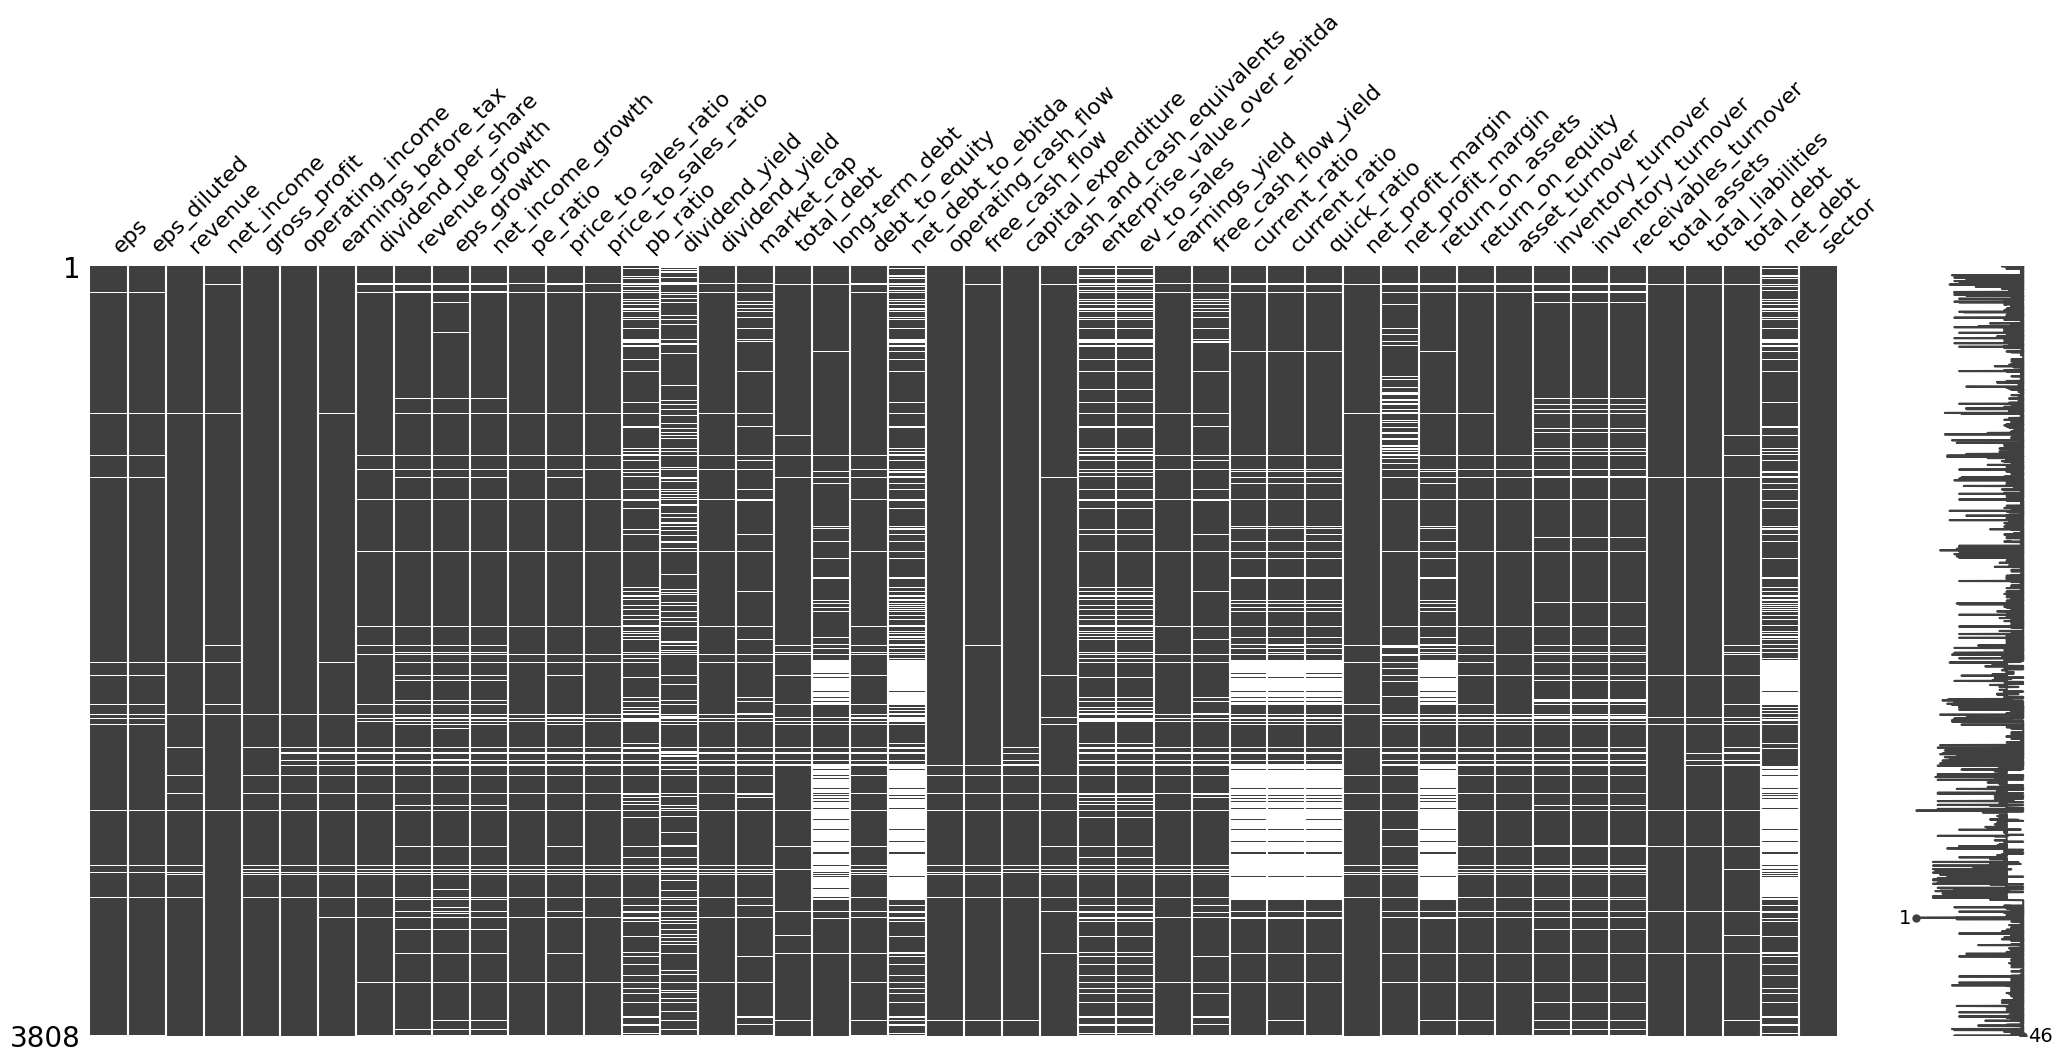

In [56]:
# Visualize the missingness pattern
msno.matrix(predictors2014_selected)

<Axes: >

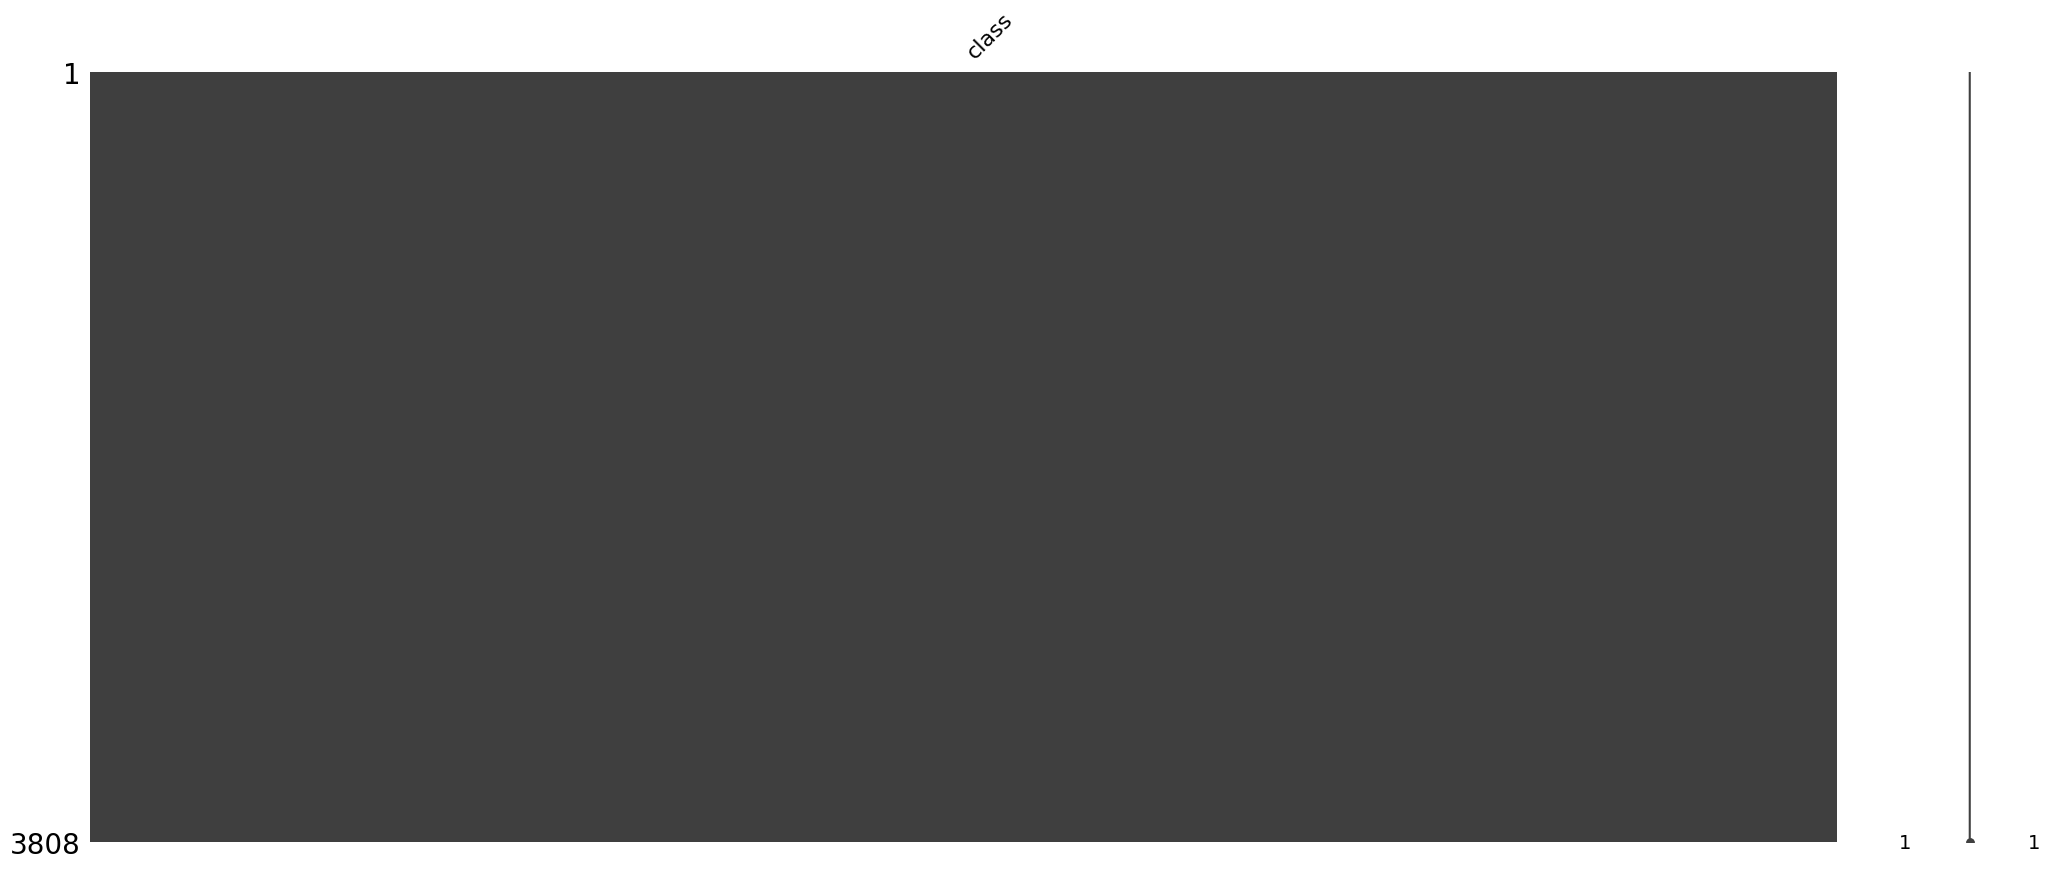

In [67]:
msno.matrix(class2014)

<Axes: >

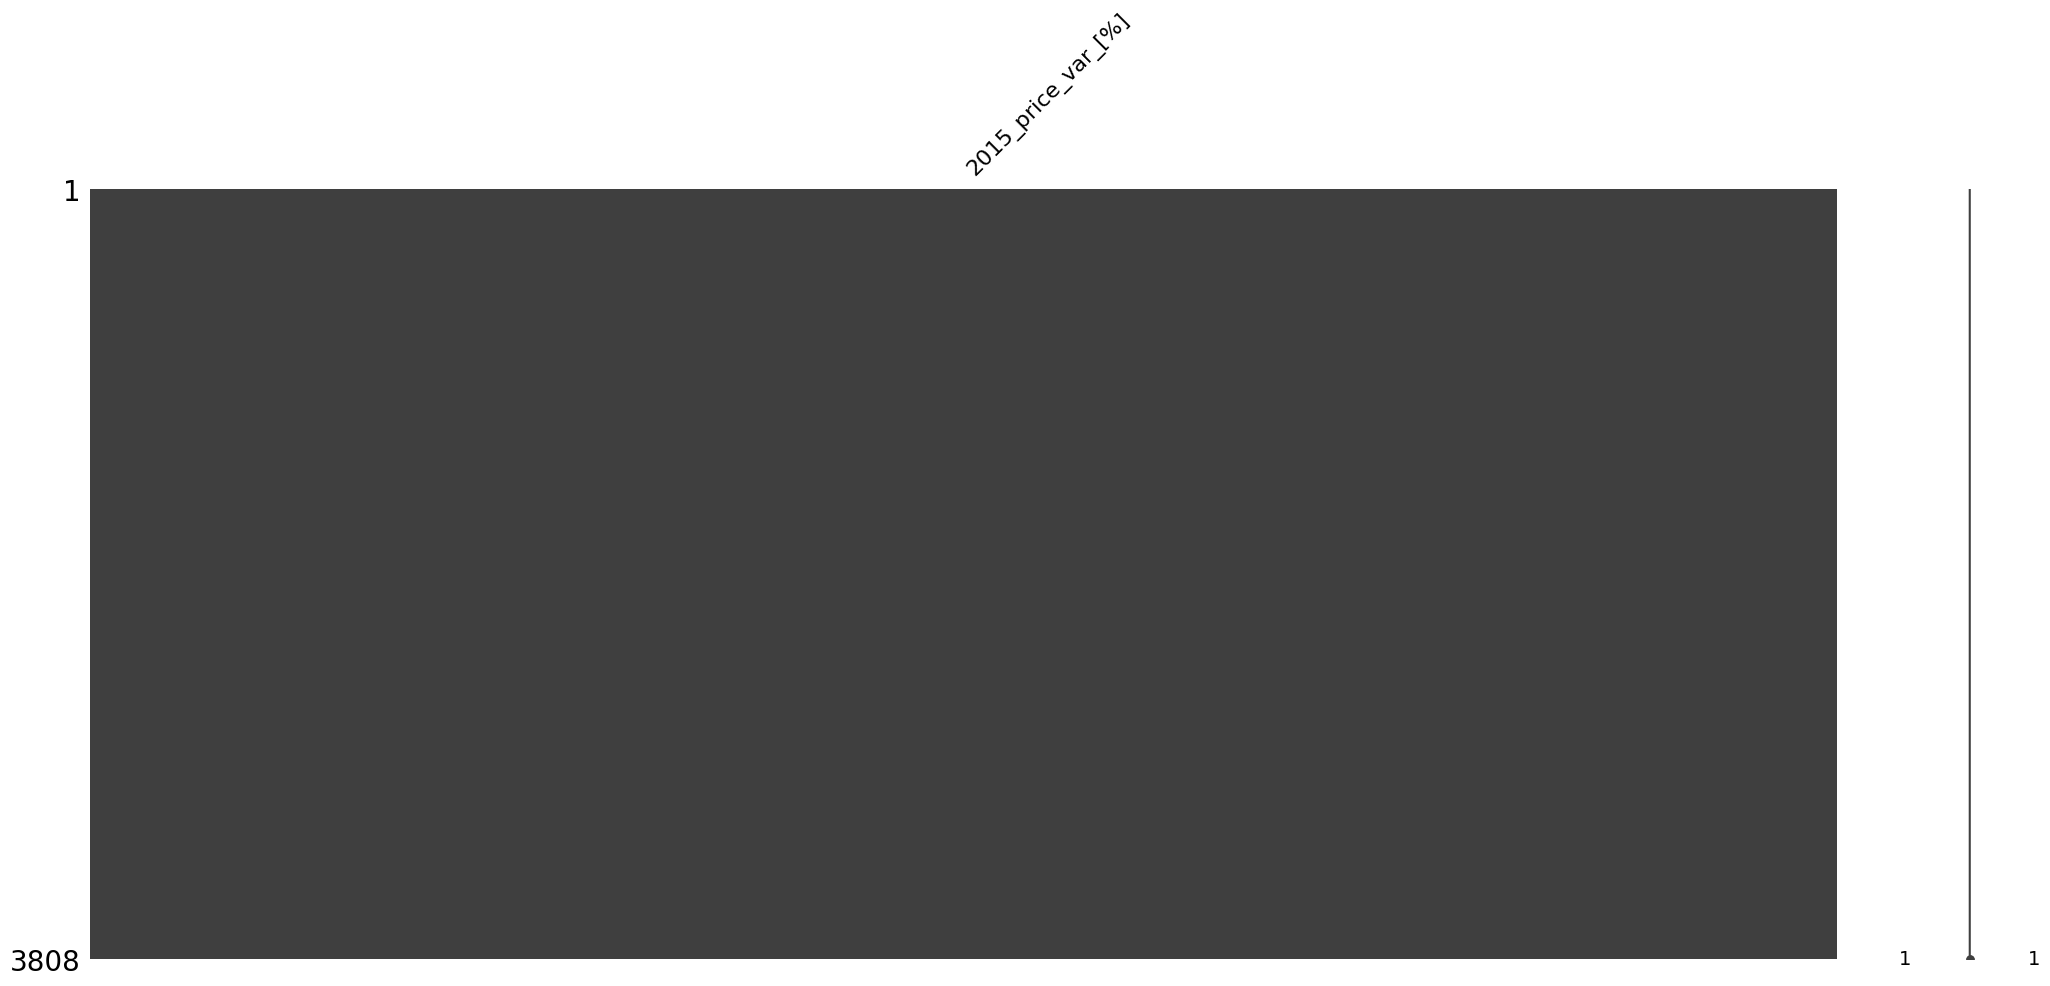

In [68]:
msno.matrix(price_var2014)

<Axes: >

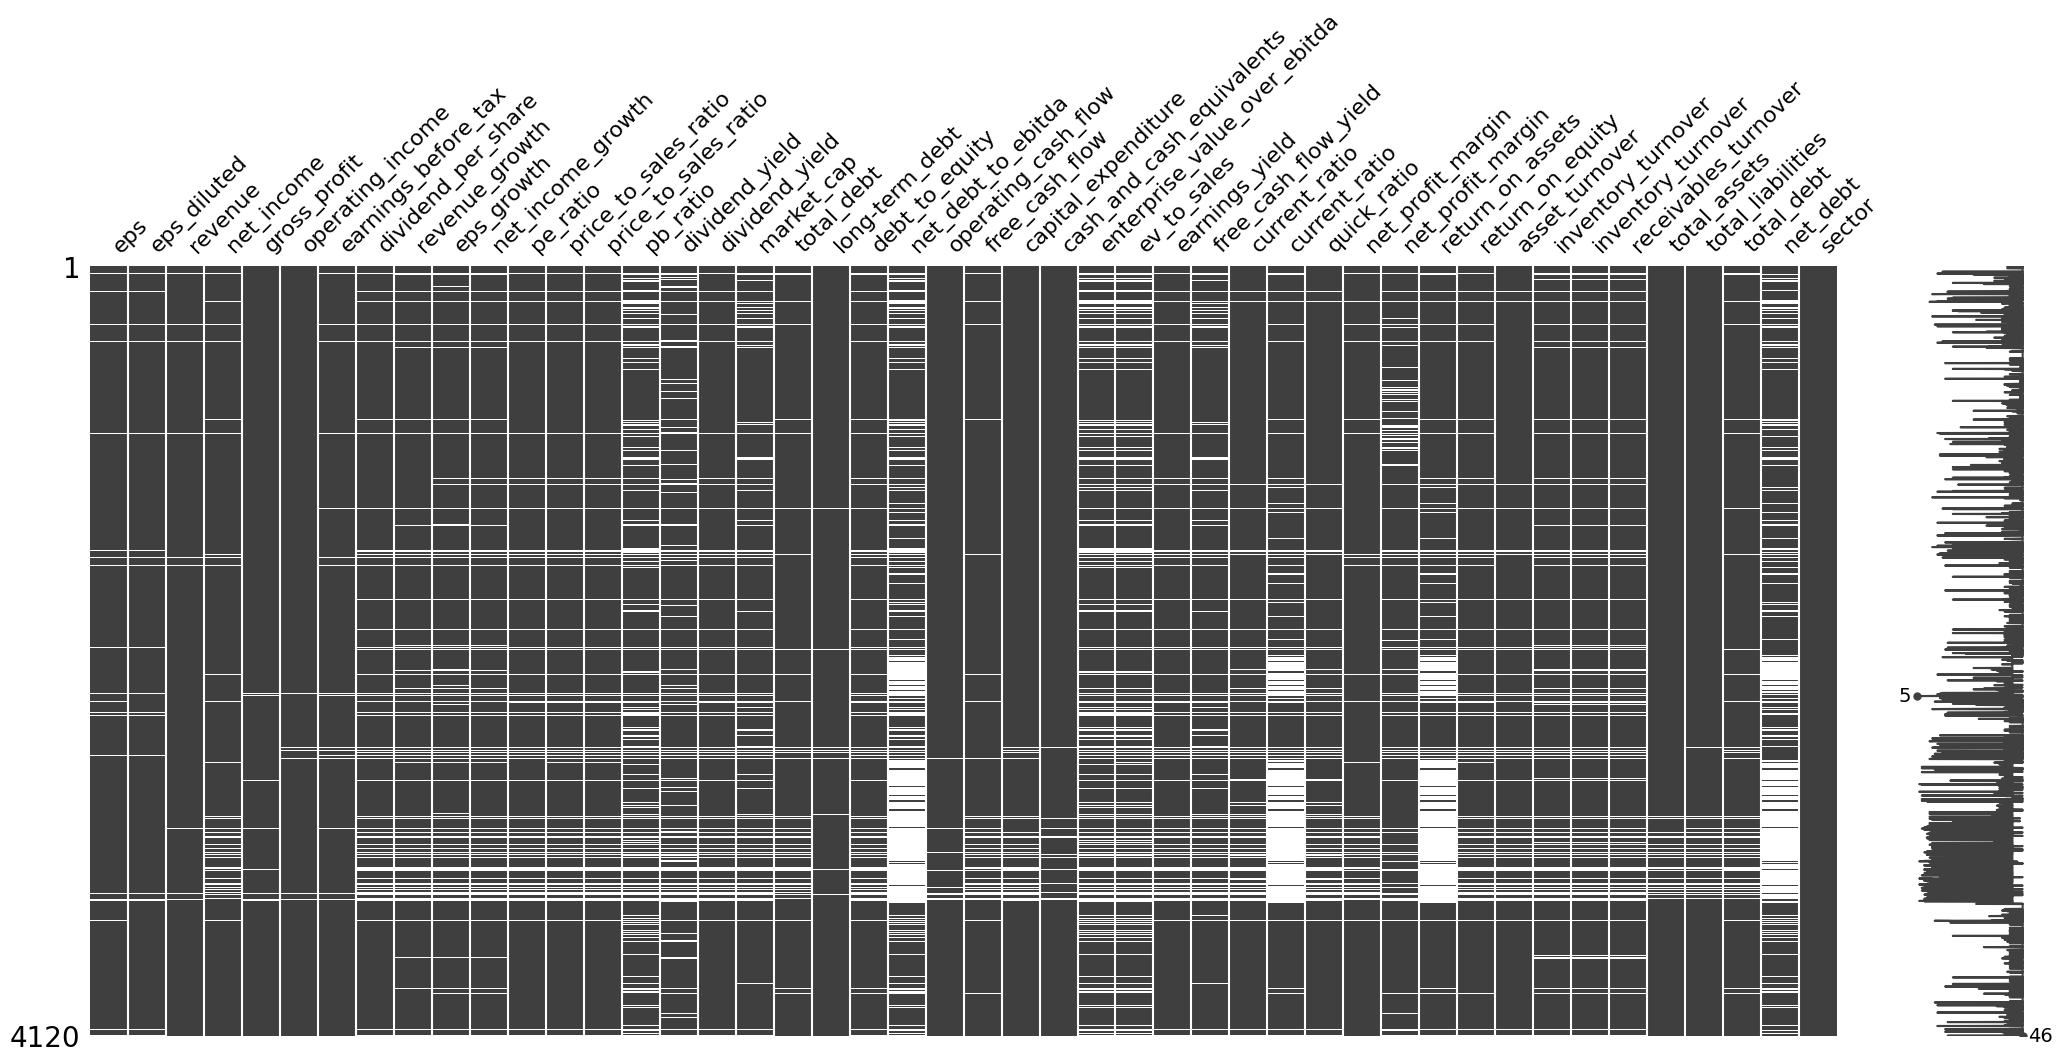

In [57]:
msno.matrix(predictors2015_selected)

<Axes: >

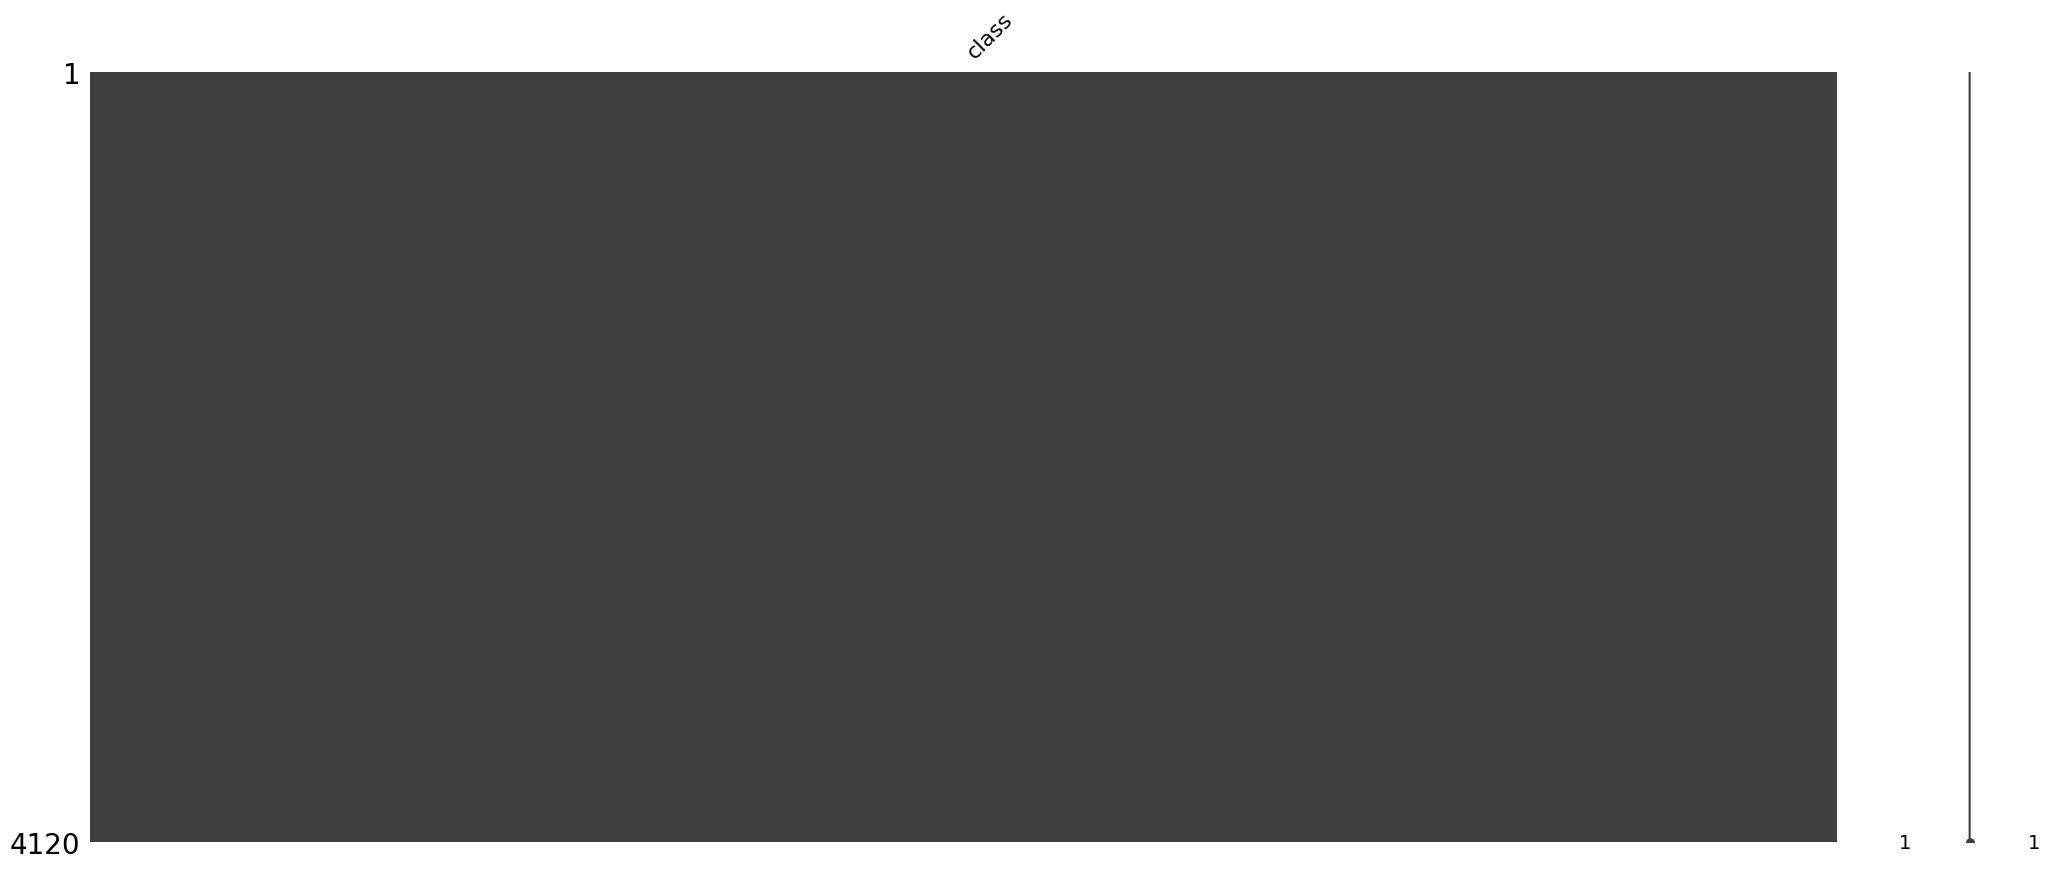

In [69]:
msno.matrix(class2015)

<Axes: >

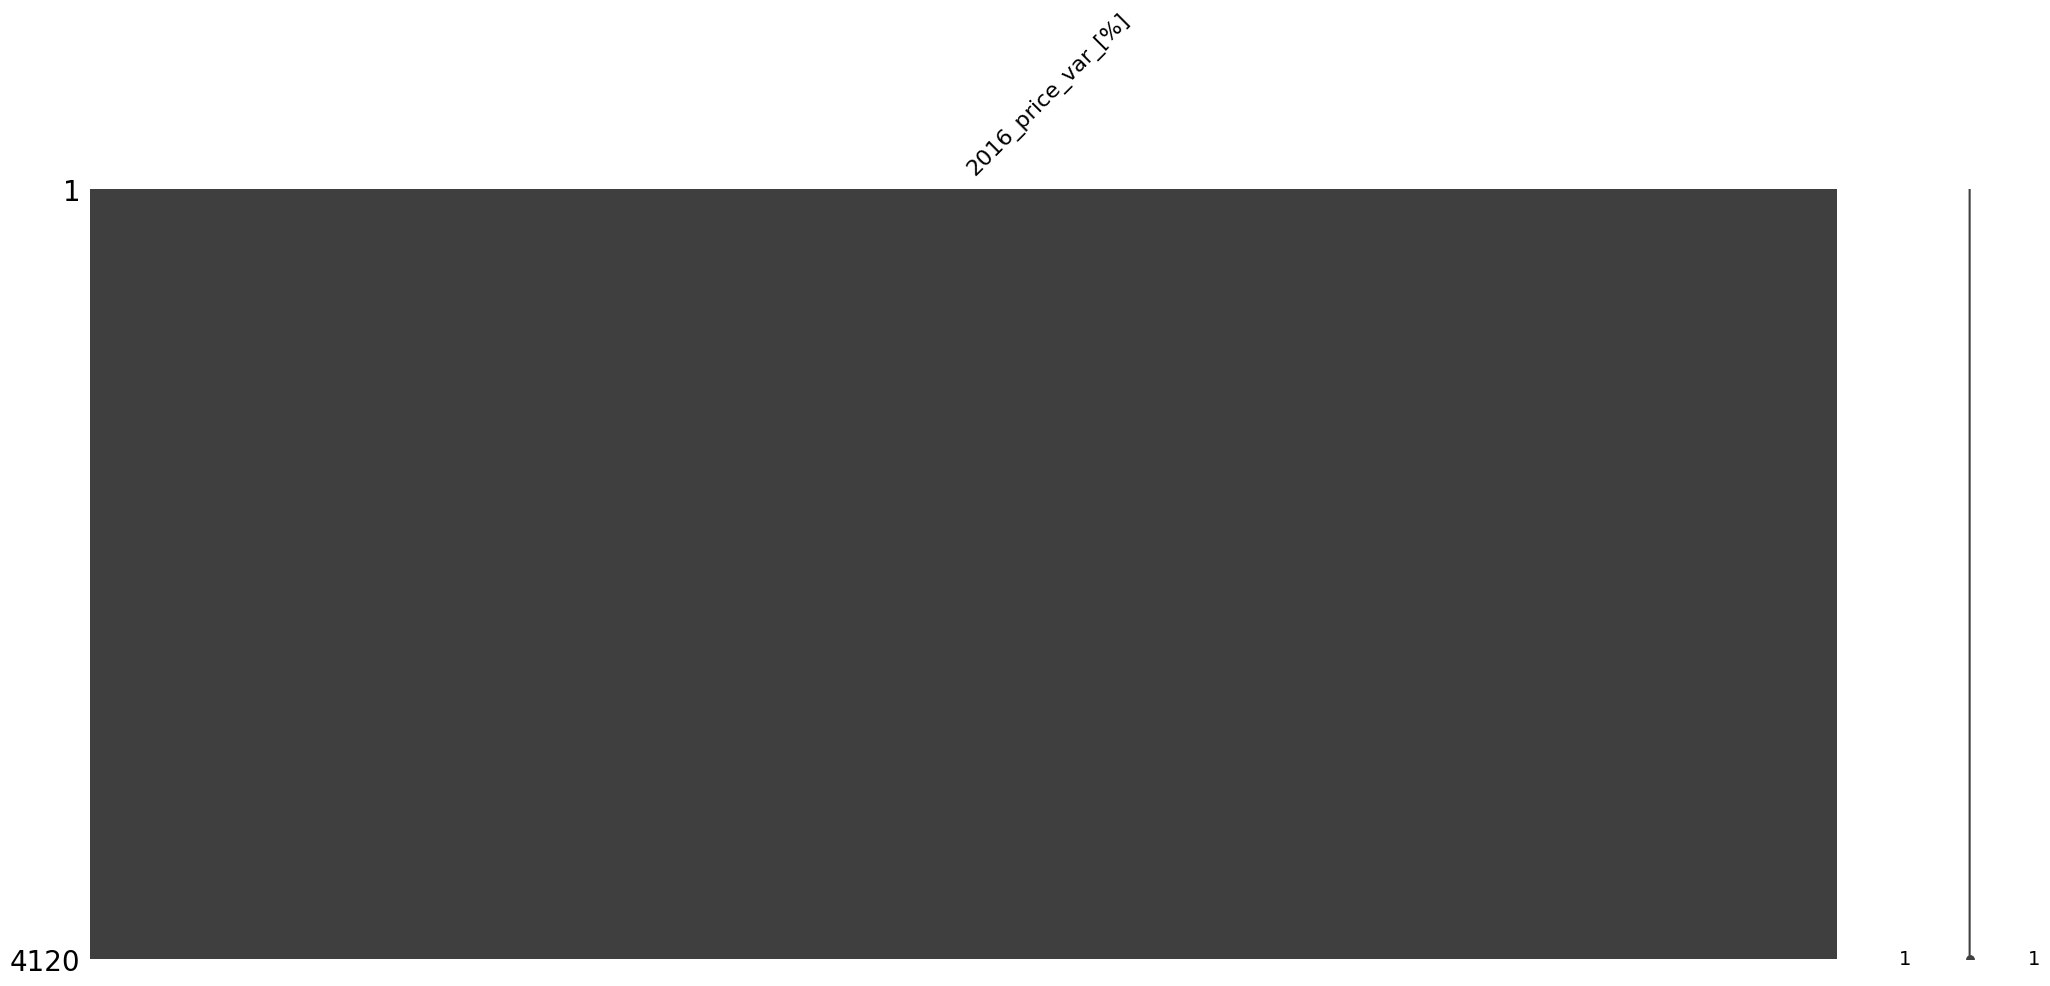

In [70]:
msno.matrix(price_var2015)

<Axes: >

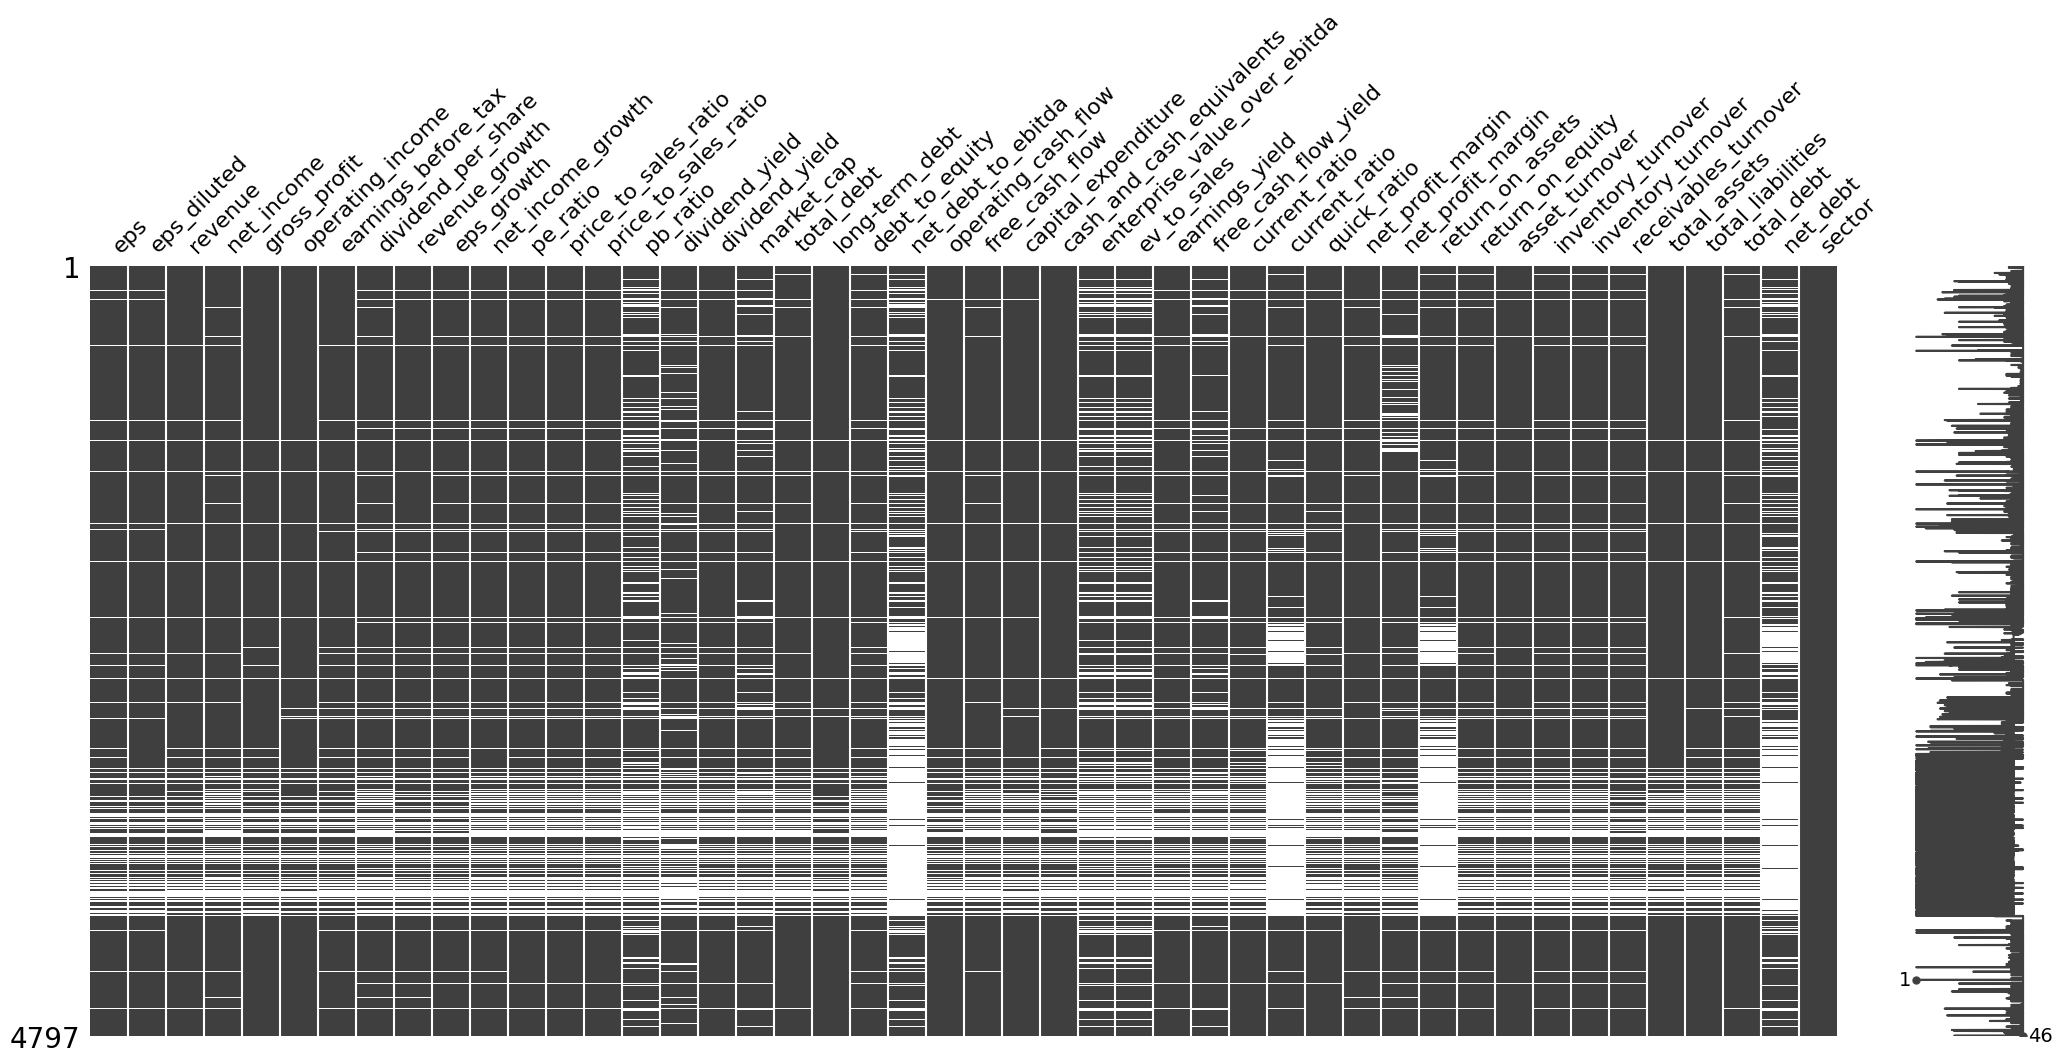

In [58]:
msno.matrix(predictors2016_selected)

<Axes: >

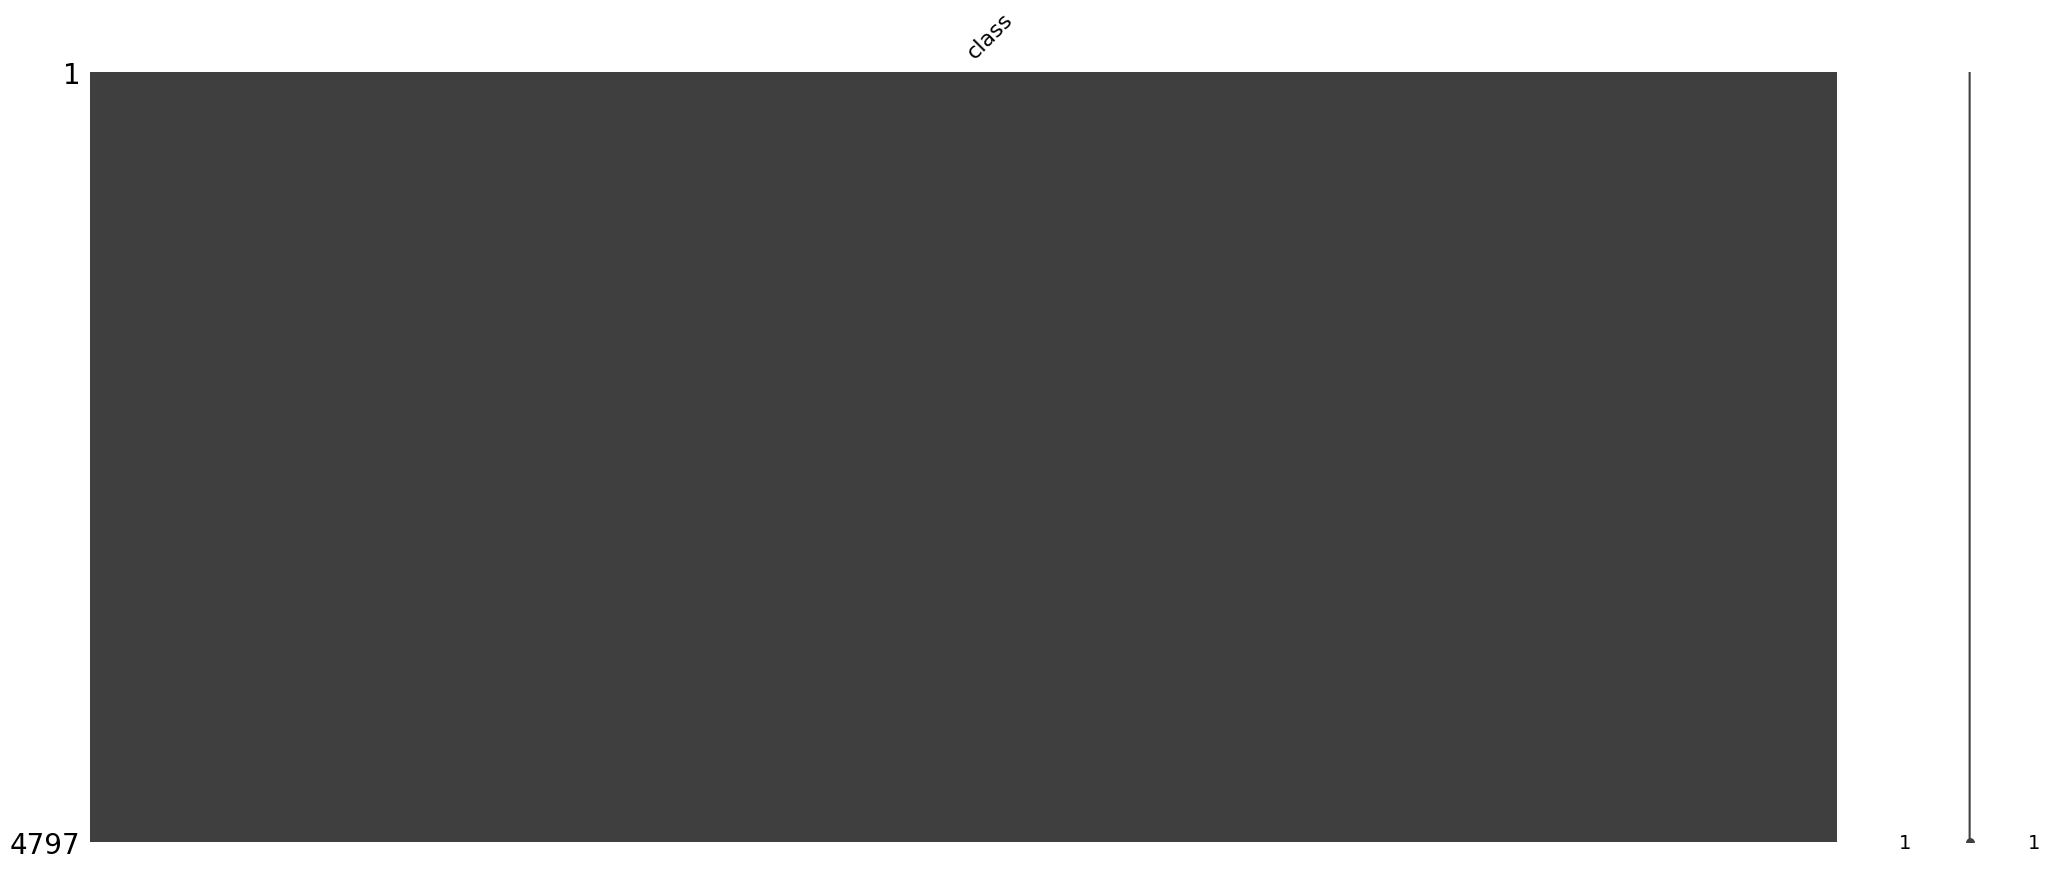

In [71]:
msno.matrix(class2016)

<Axes: >

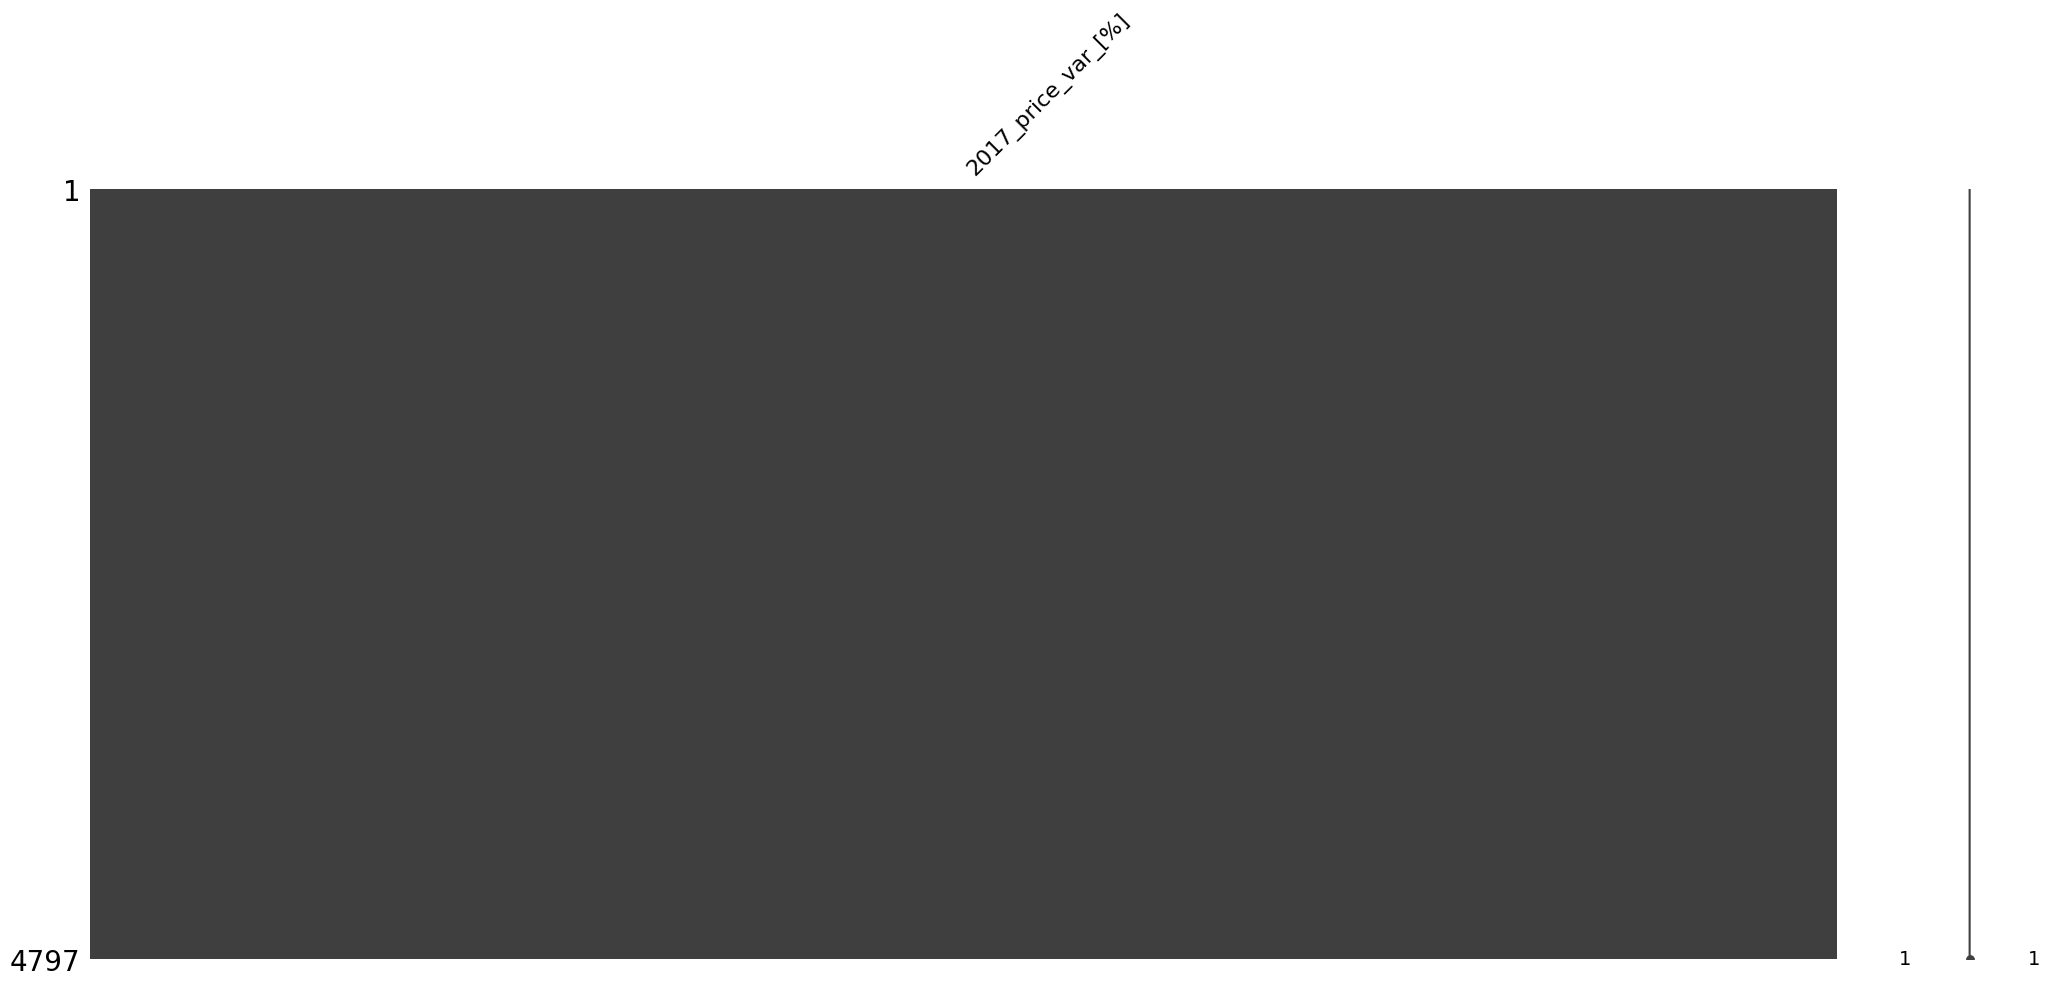

In [72]:
msno.matrix(price_var2016)

<Axes: >

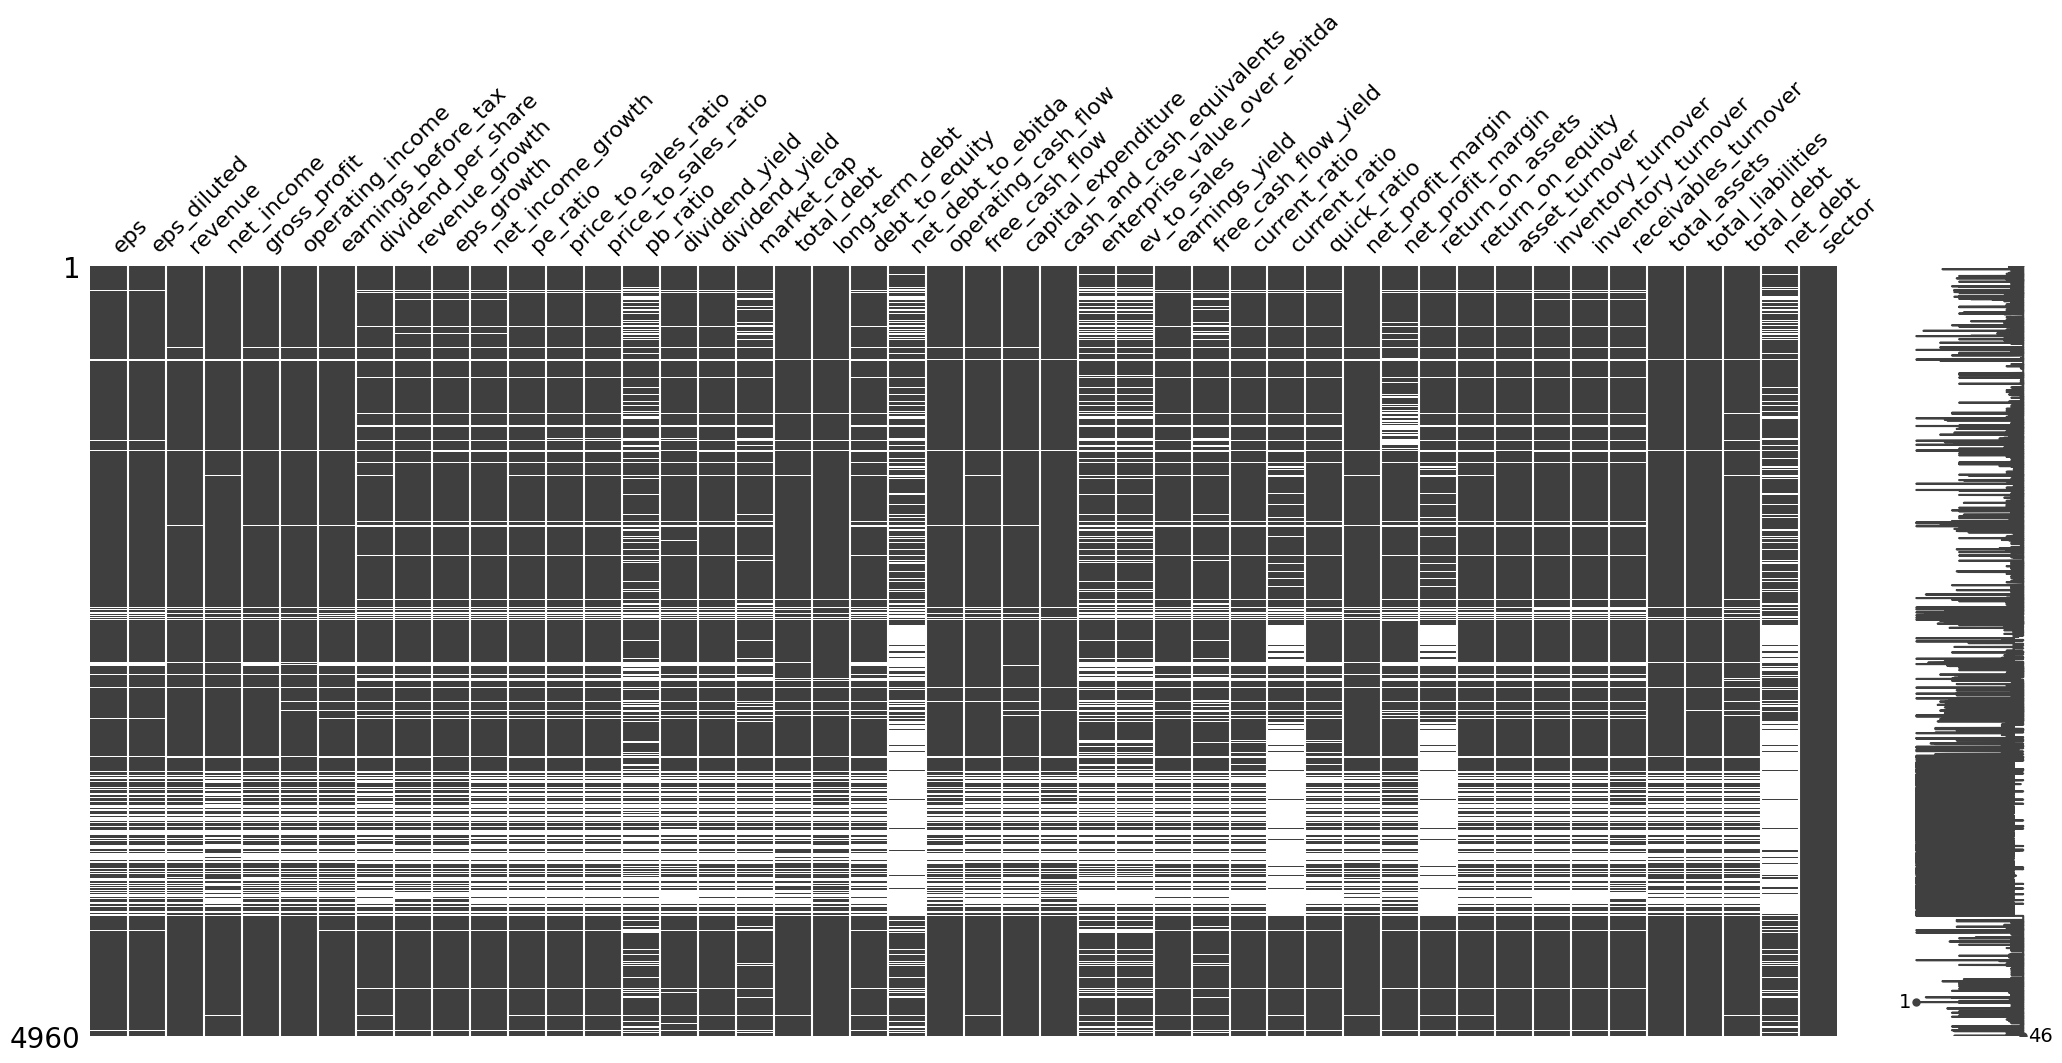

In [59]:
msno.matrix(predictors2017_selected)

<Axes: >

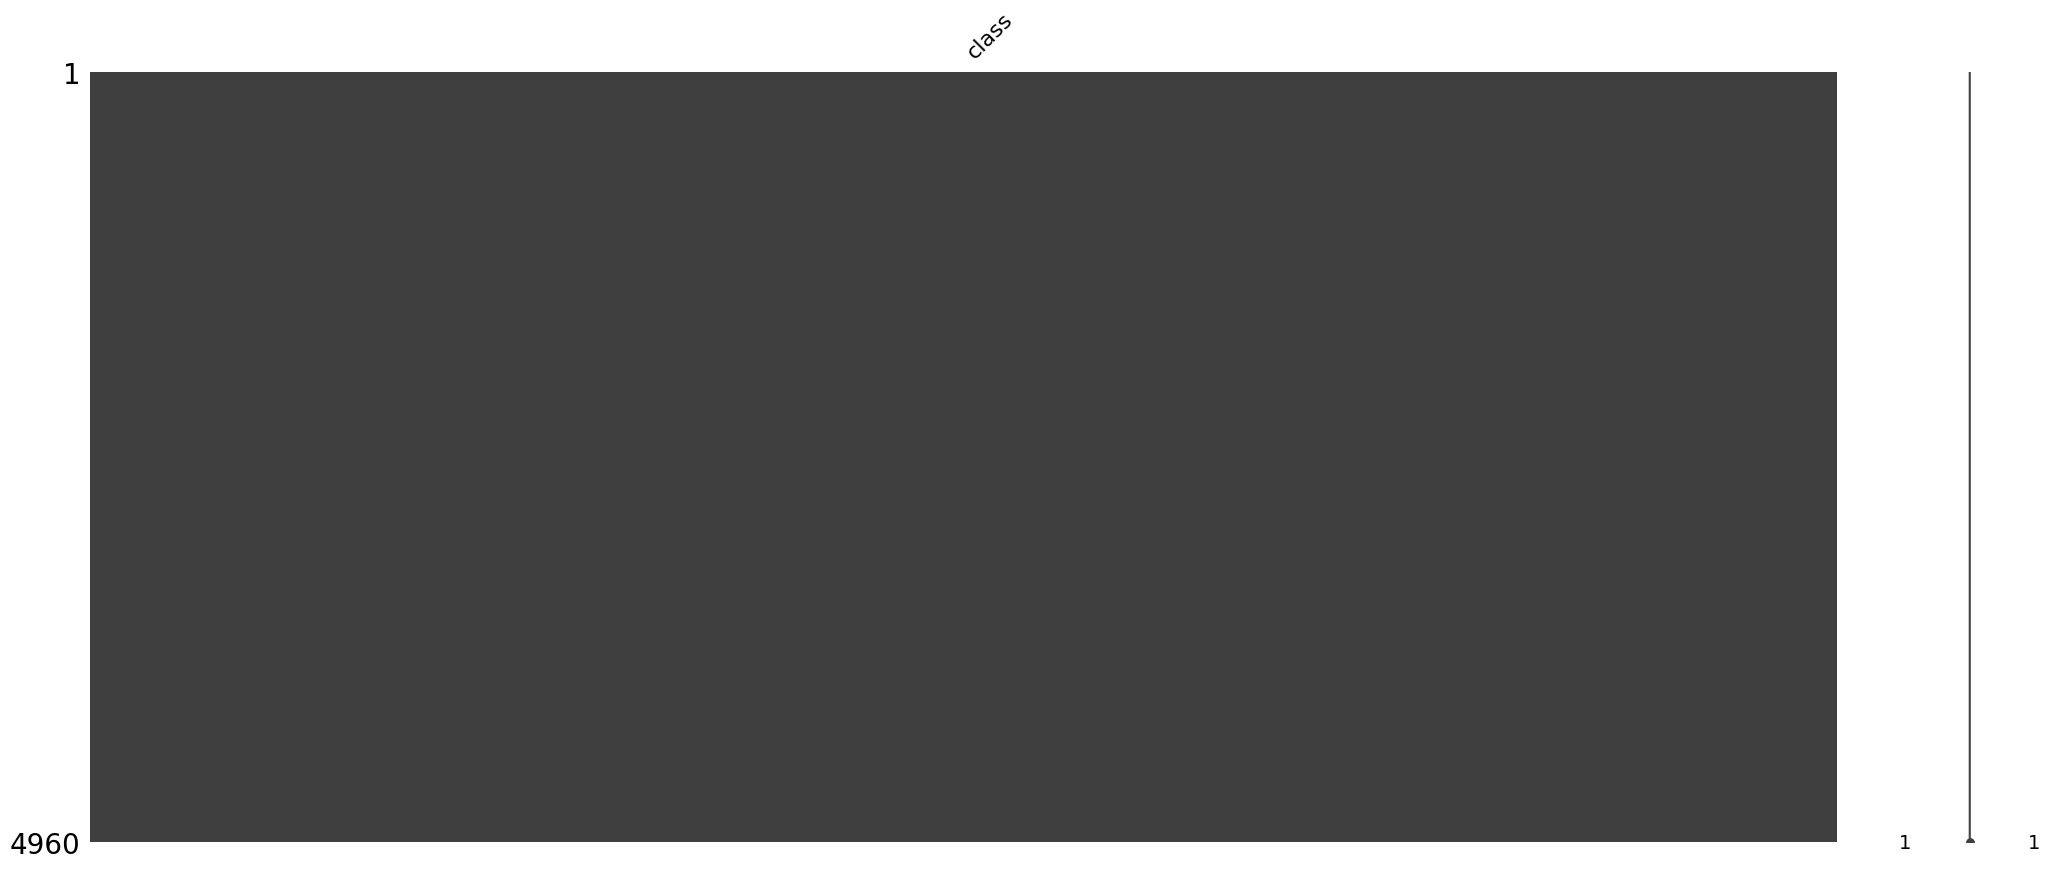

In [73]:
msno.matrix(class2017)

<Axes: >

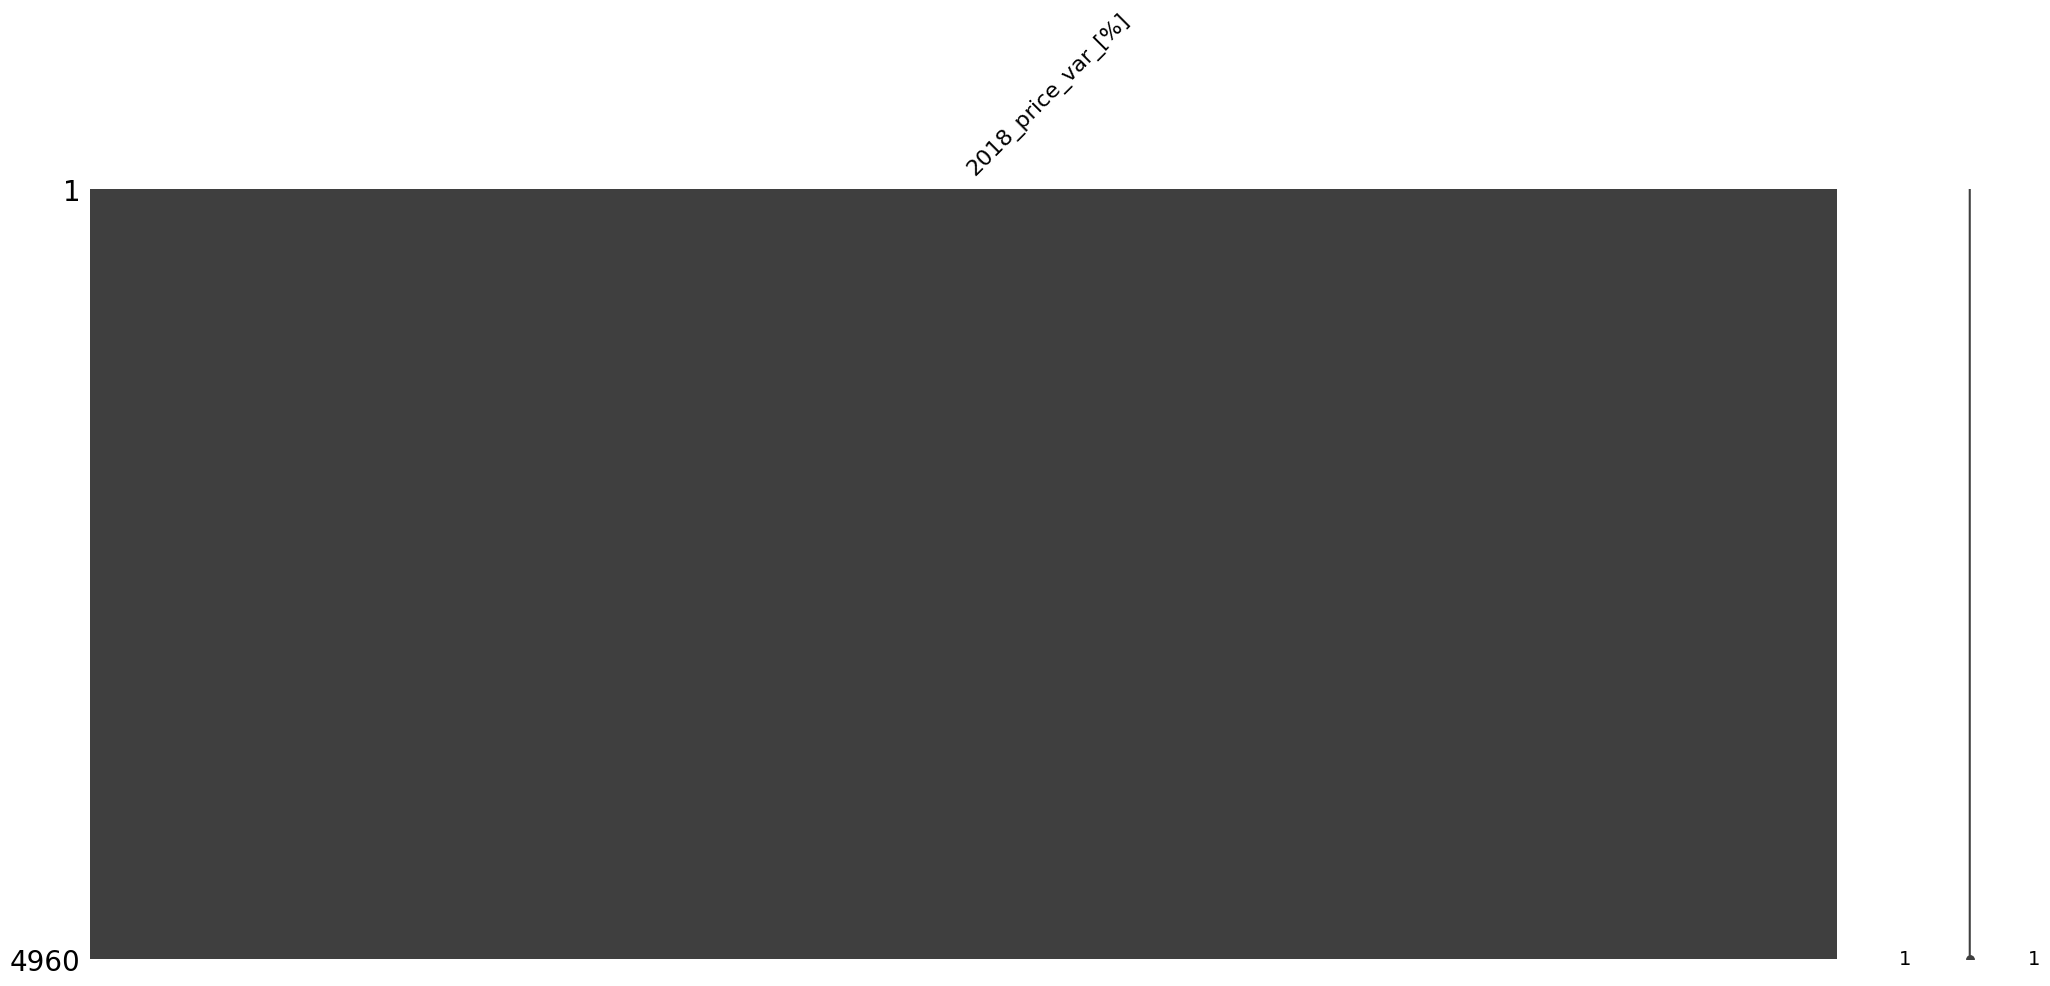

In [74]:
msno.matrix(price_var2017)

<Axes: >

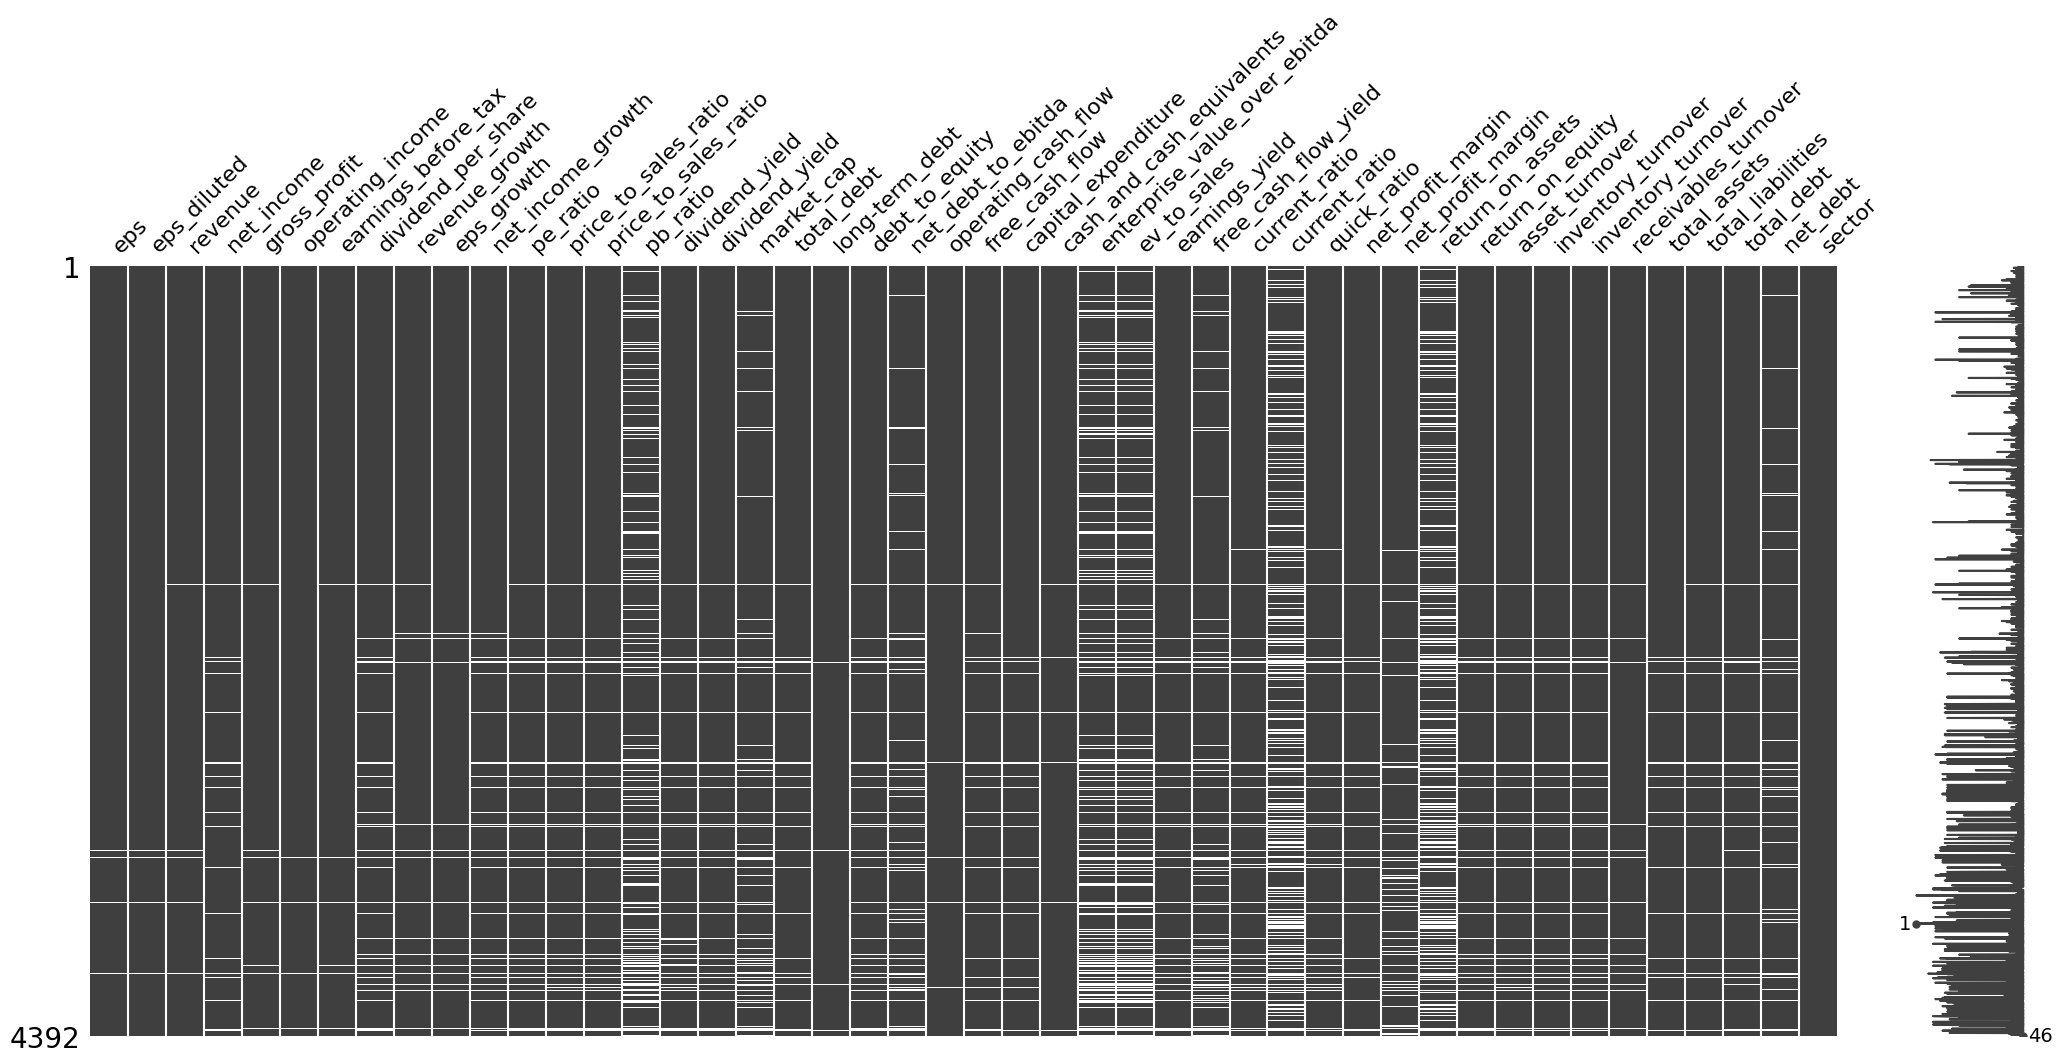

In [60]:
msno.matrix(predictors2018_selected)

<Axes: >

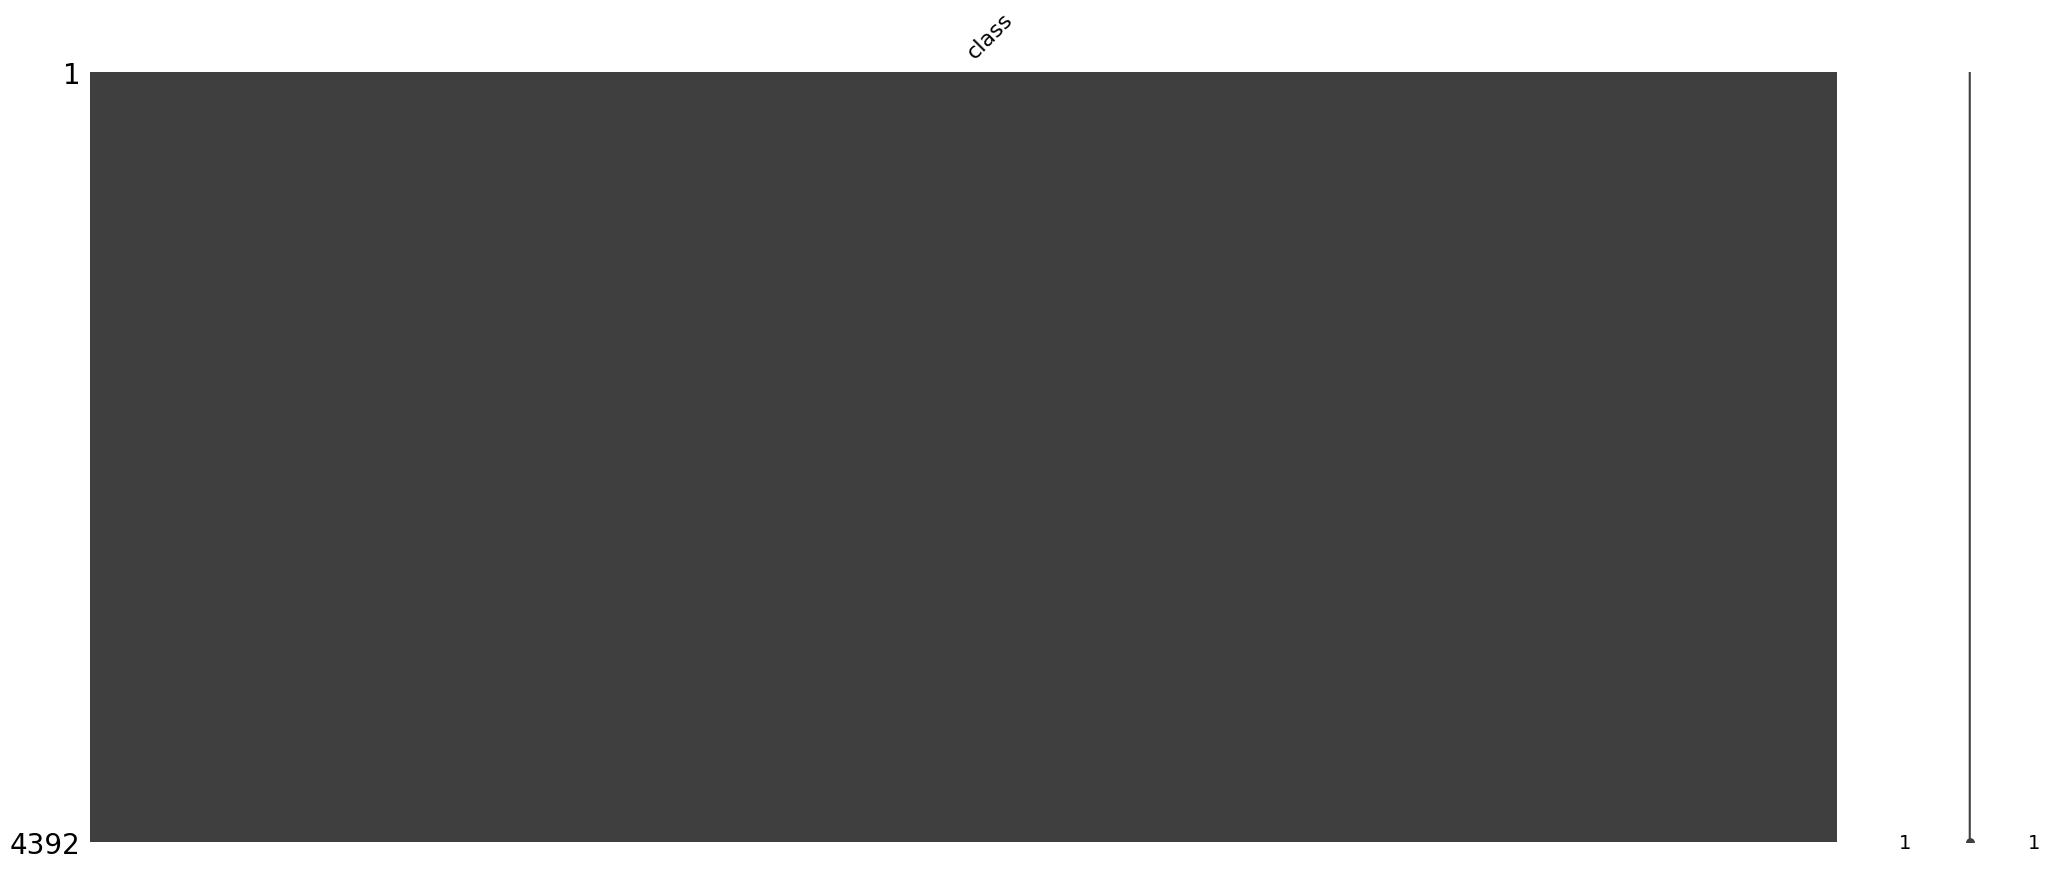

In [75]:
msno.matrix(class2018)

<Axes: >

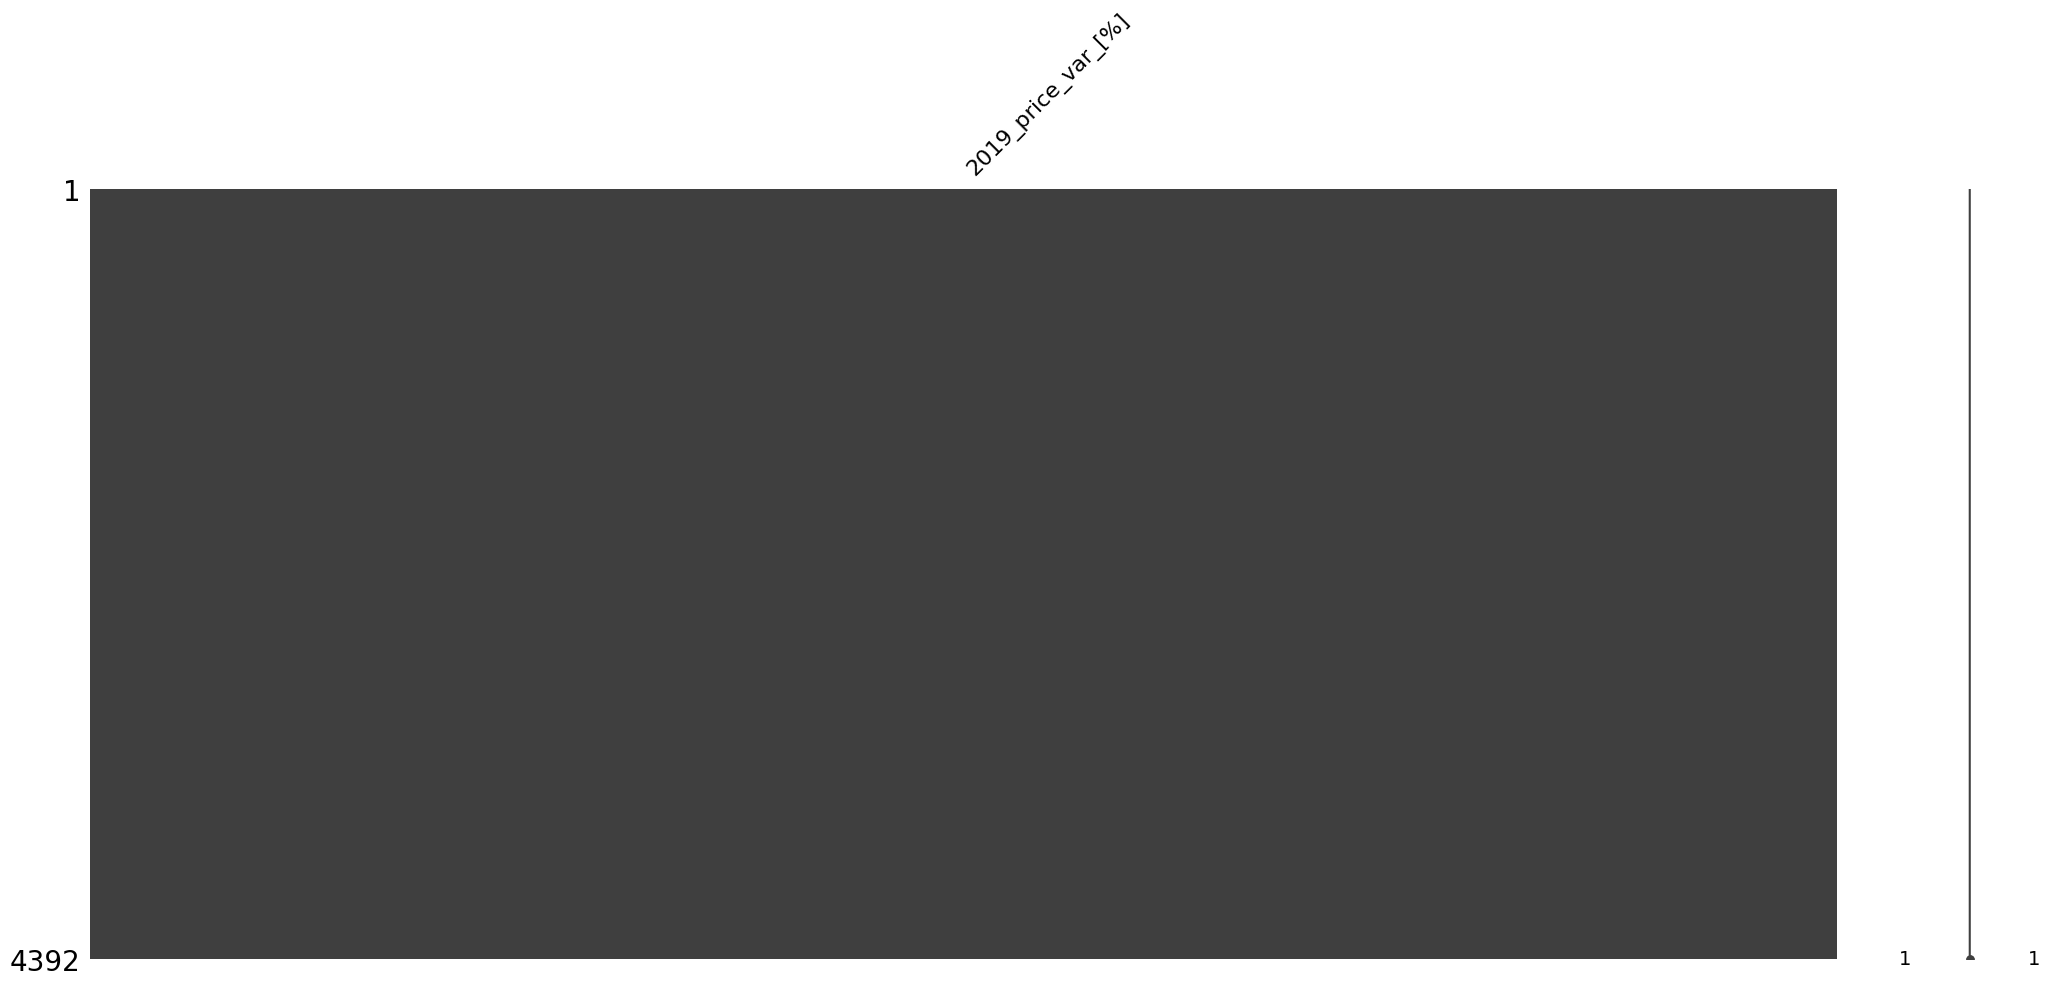

In [76]:
msno.matrix(price_var2018)

<Axes: >

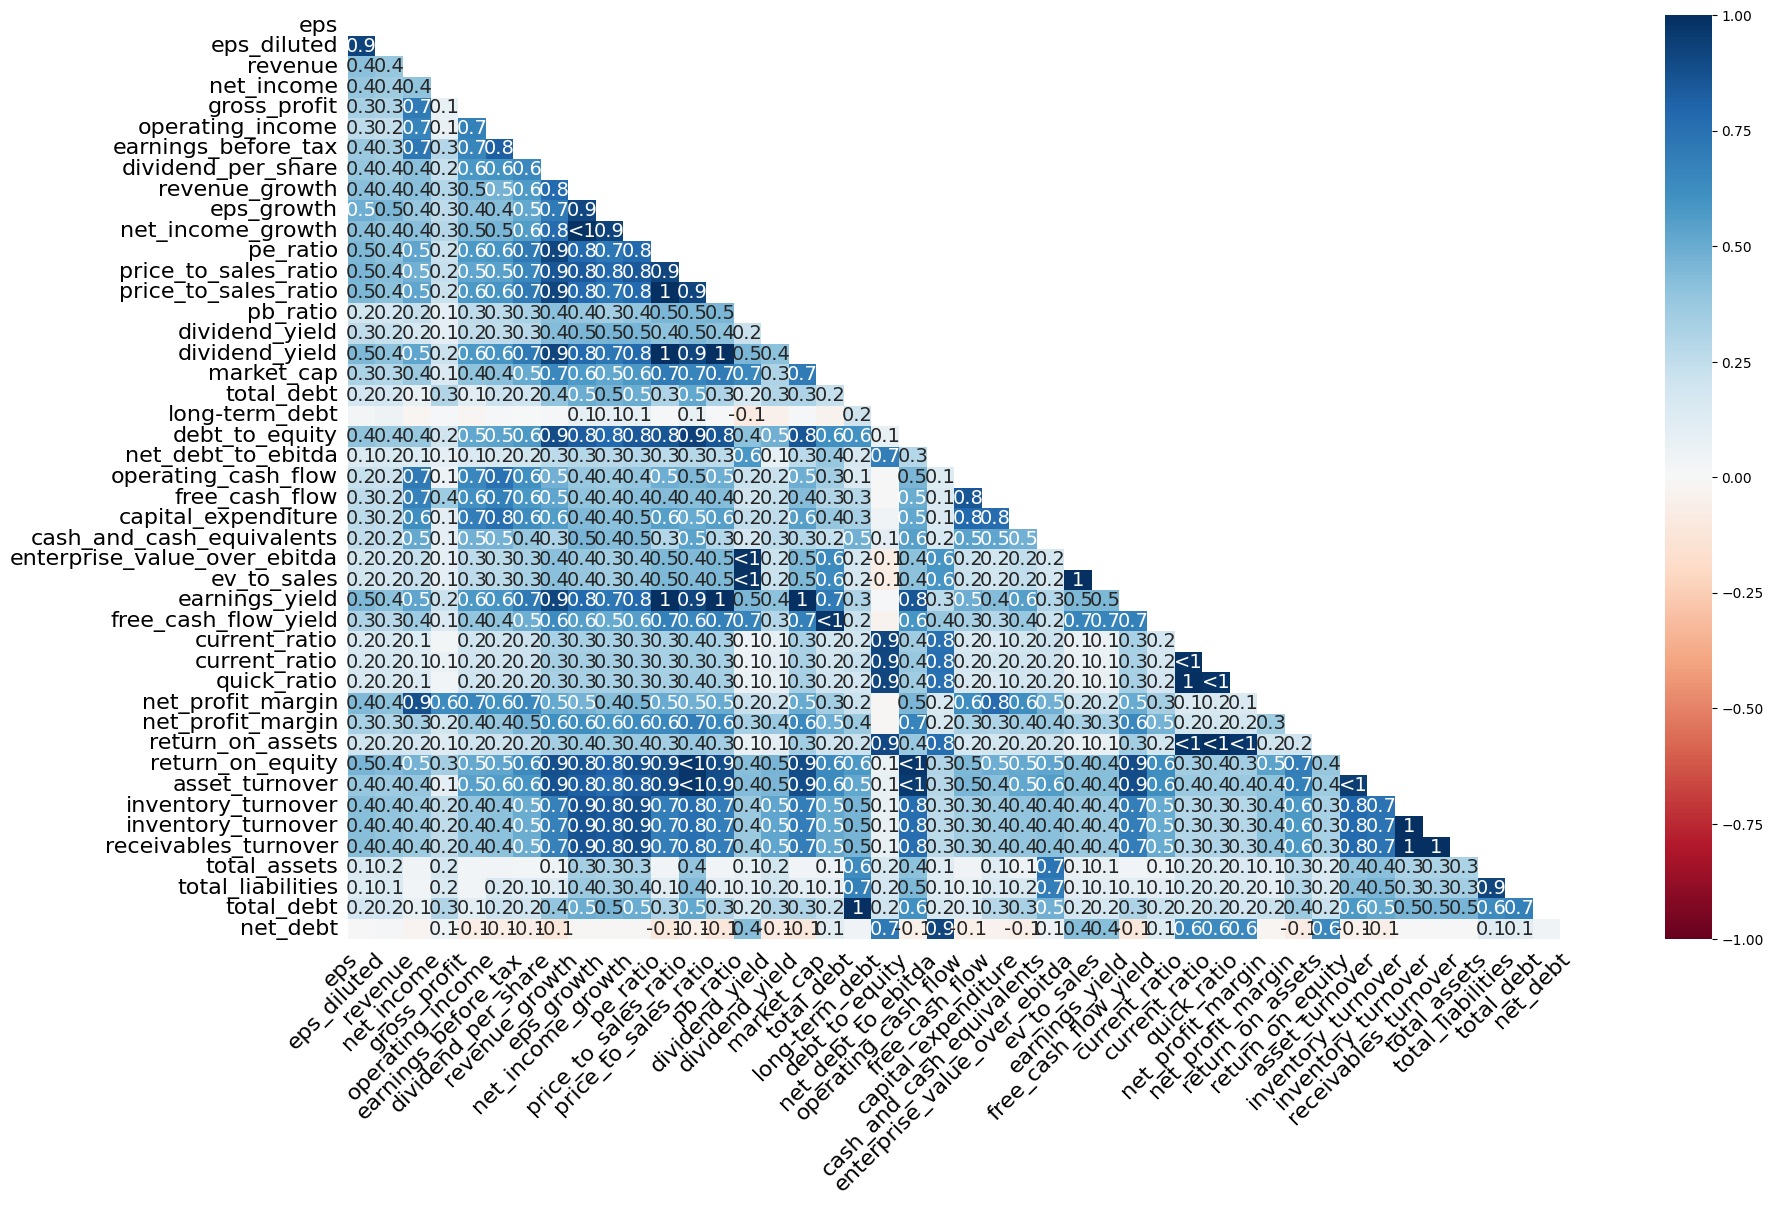

In [61]:
msno.heatmap(predictors2014_selected)

<Axes: >

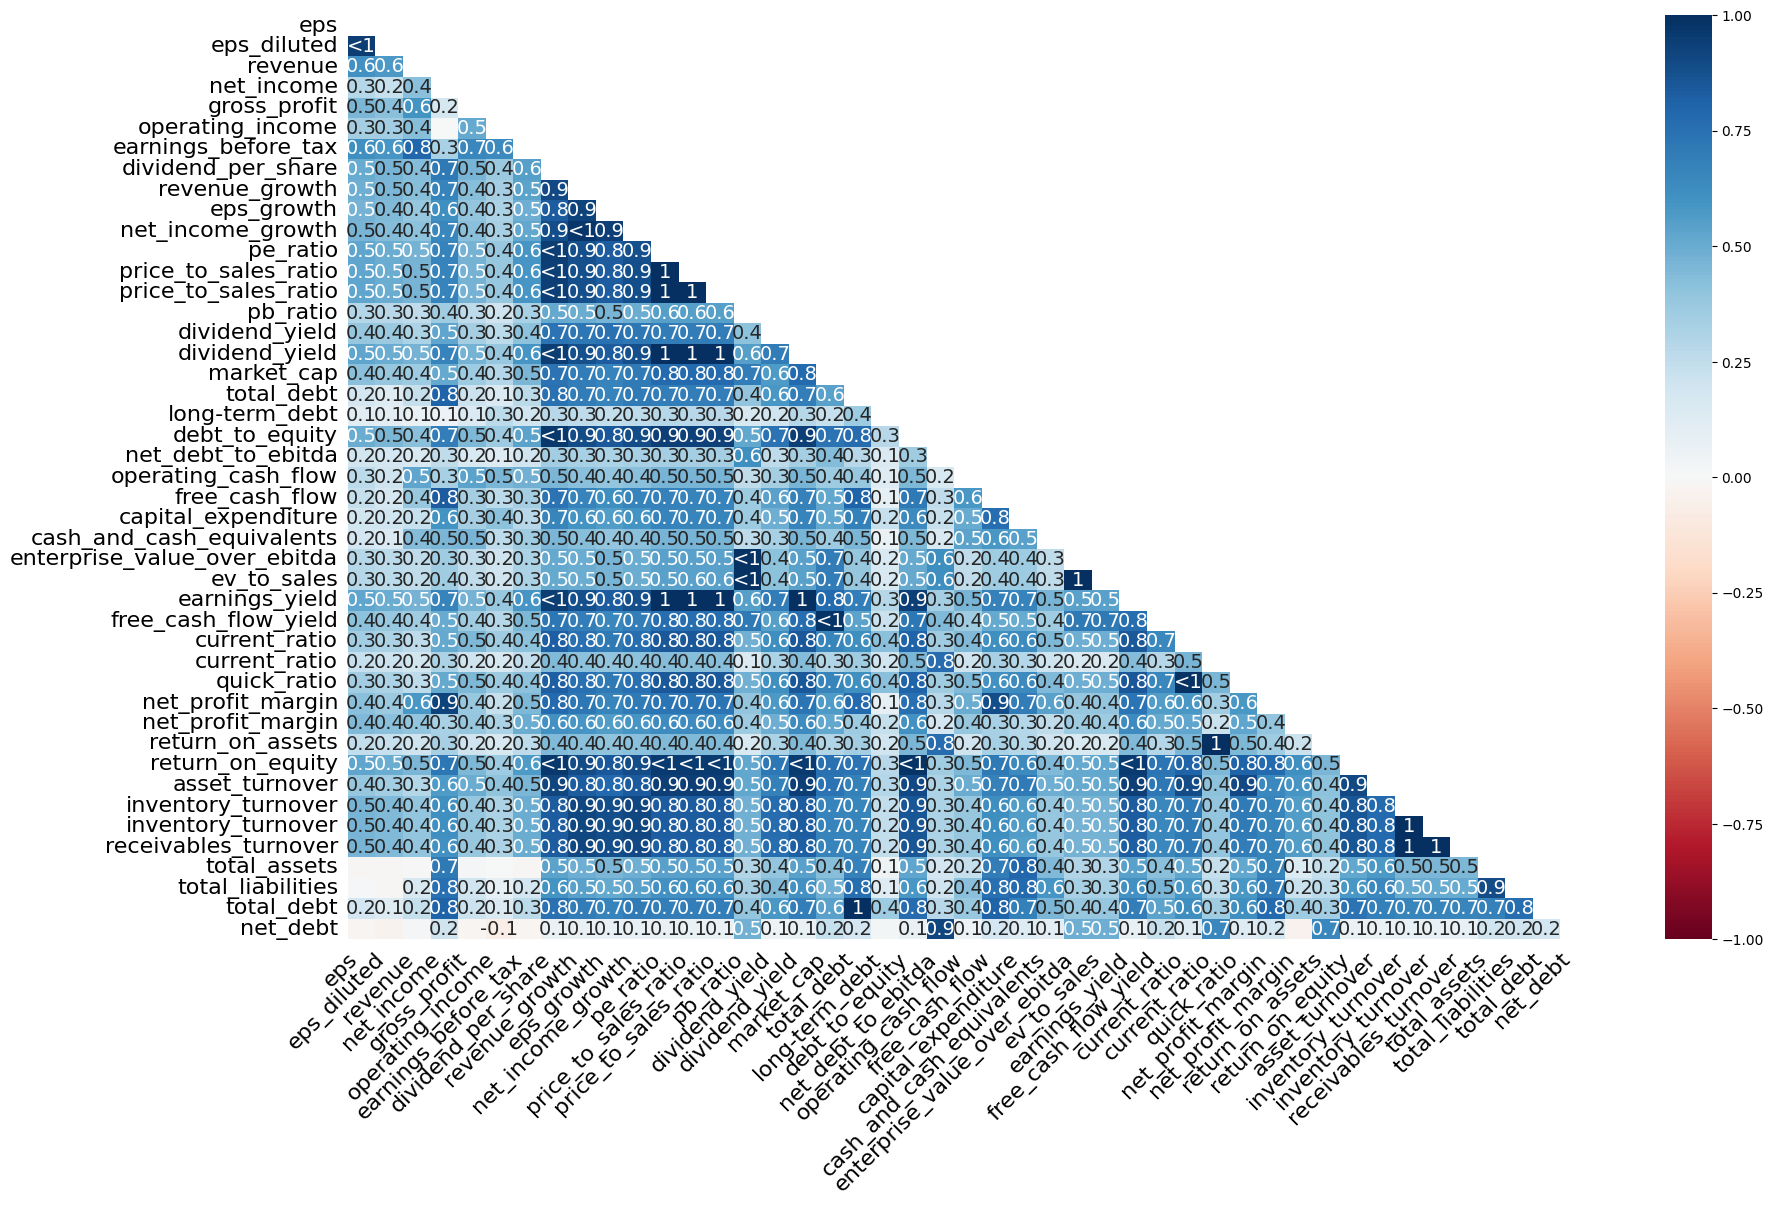

In [62]:
msno.heatmap(predictors2015_selected)

<Axes: >

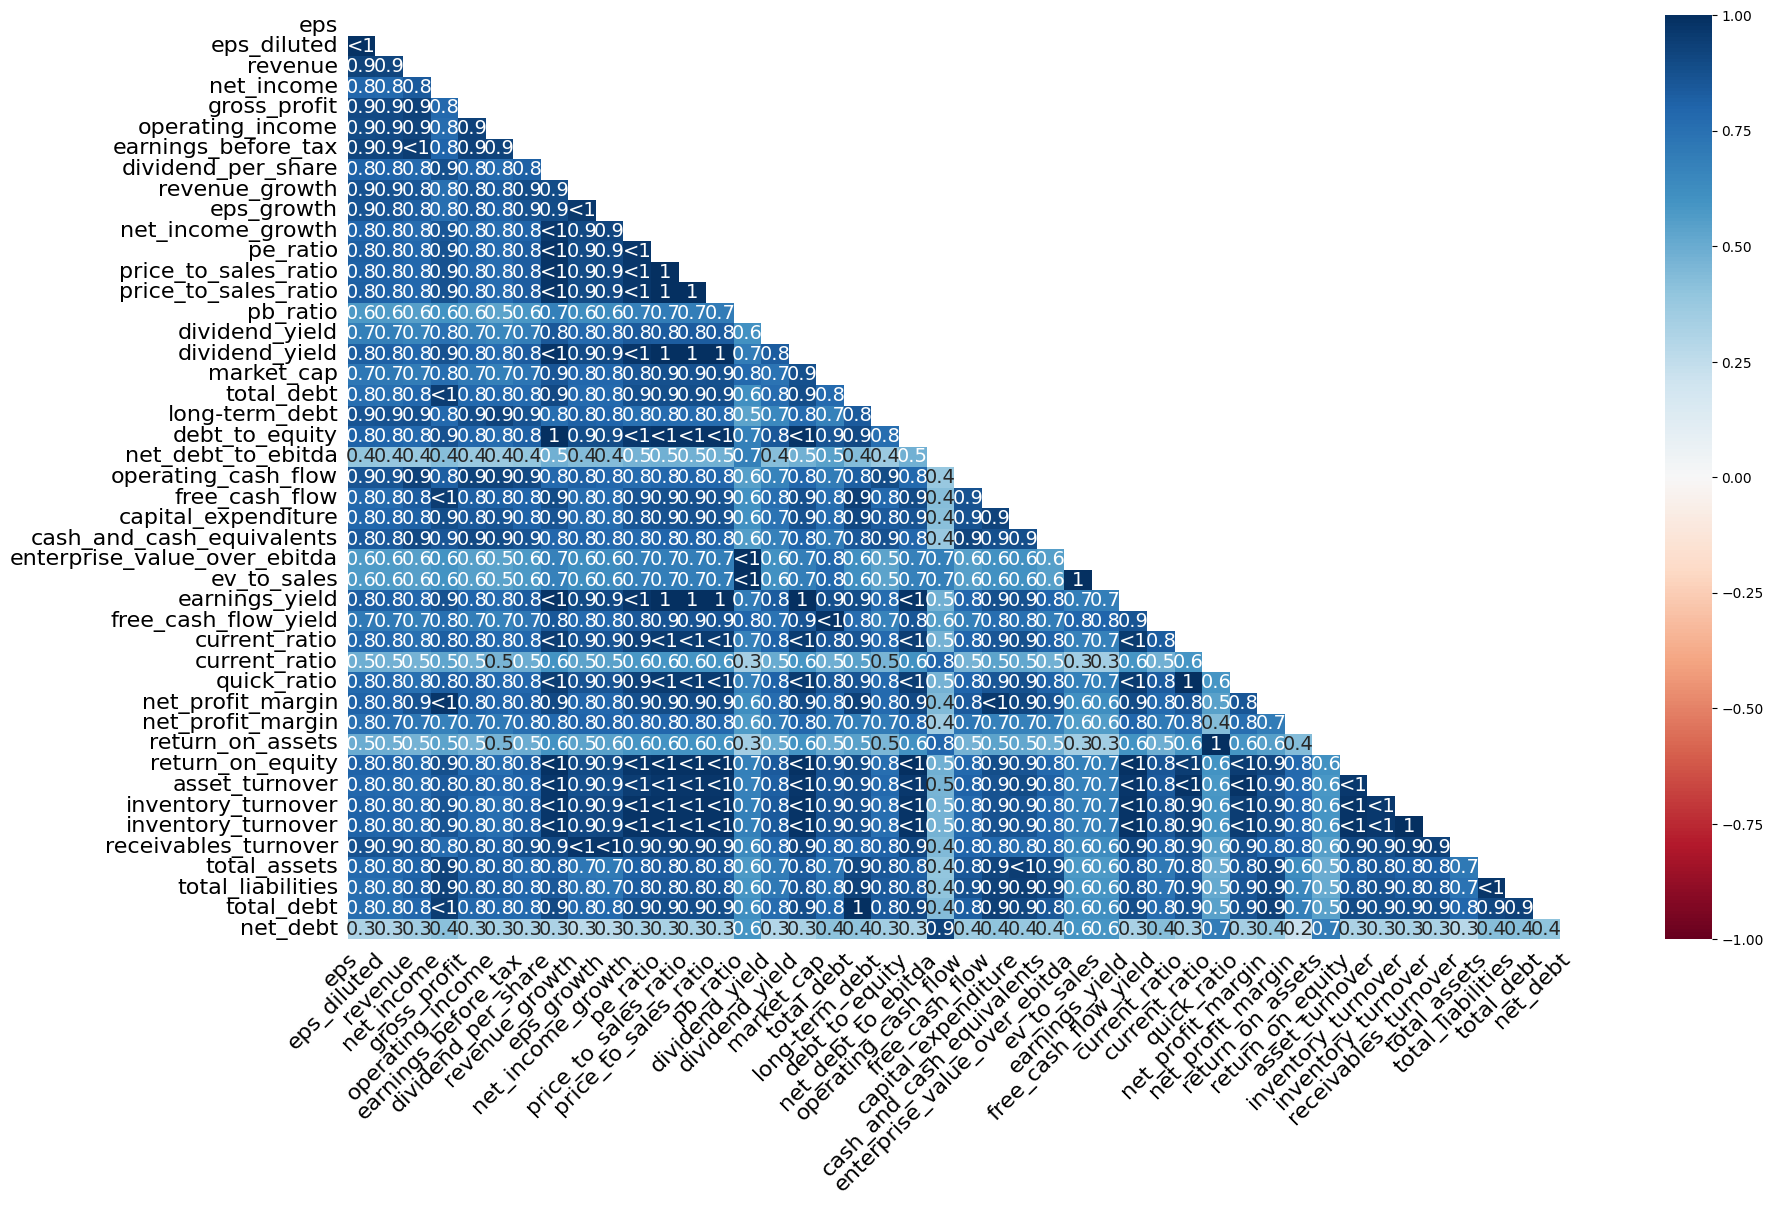

In [63]:
msno.heatmap(predictors2016_selected)

<Axes: >

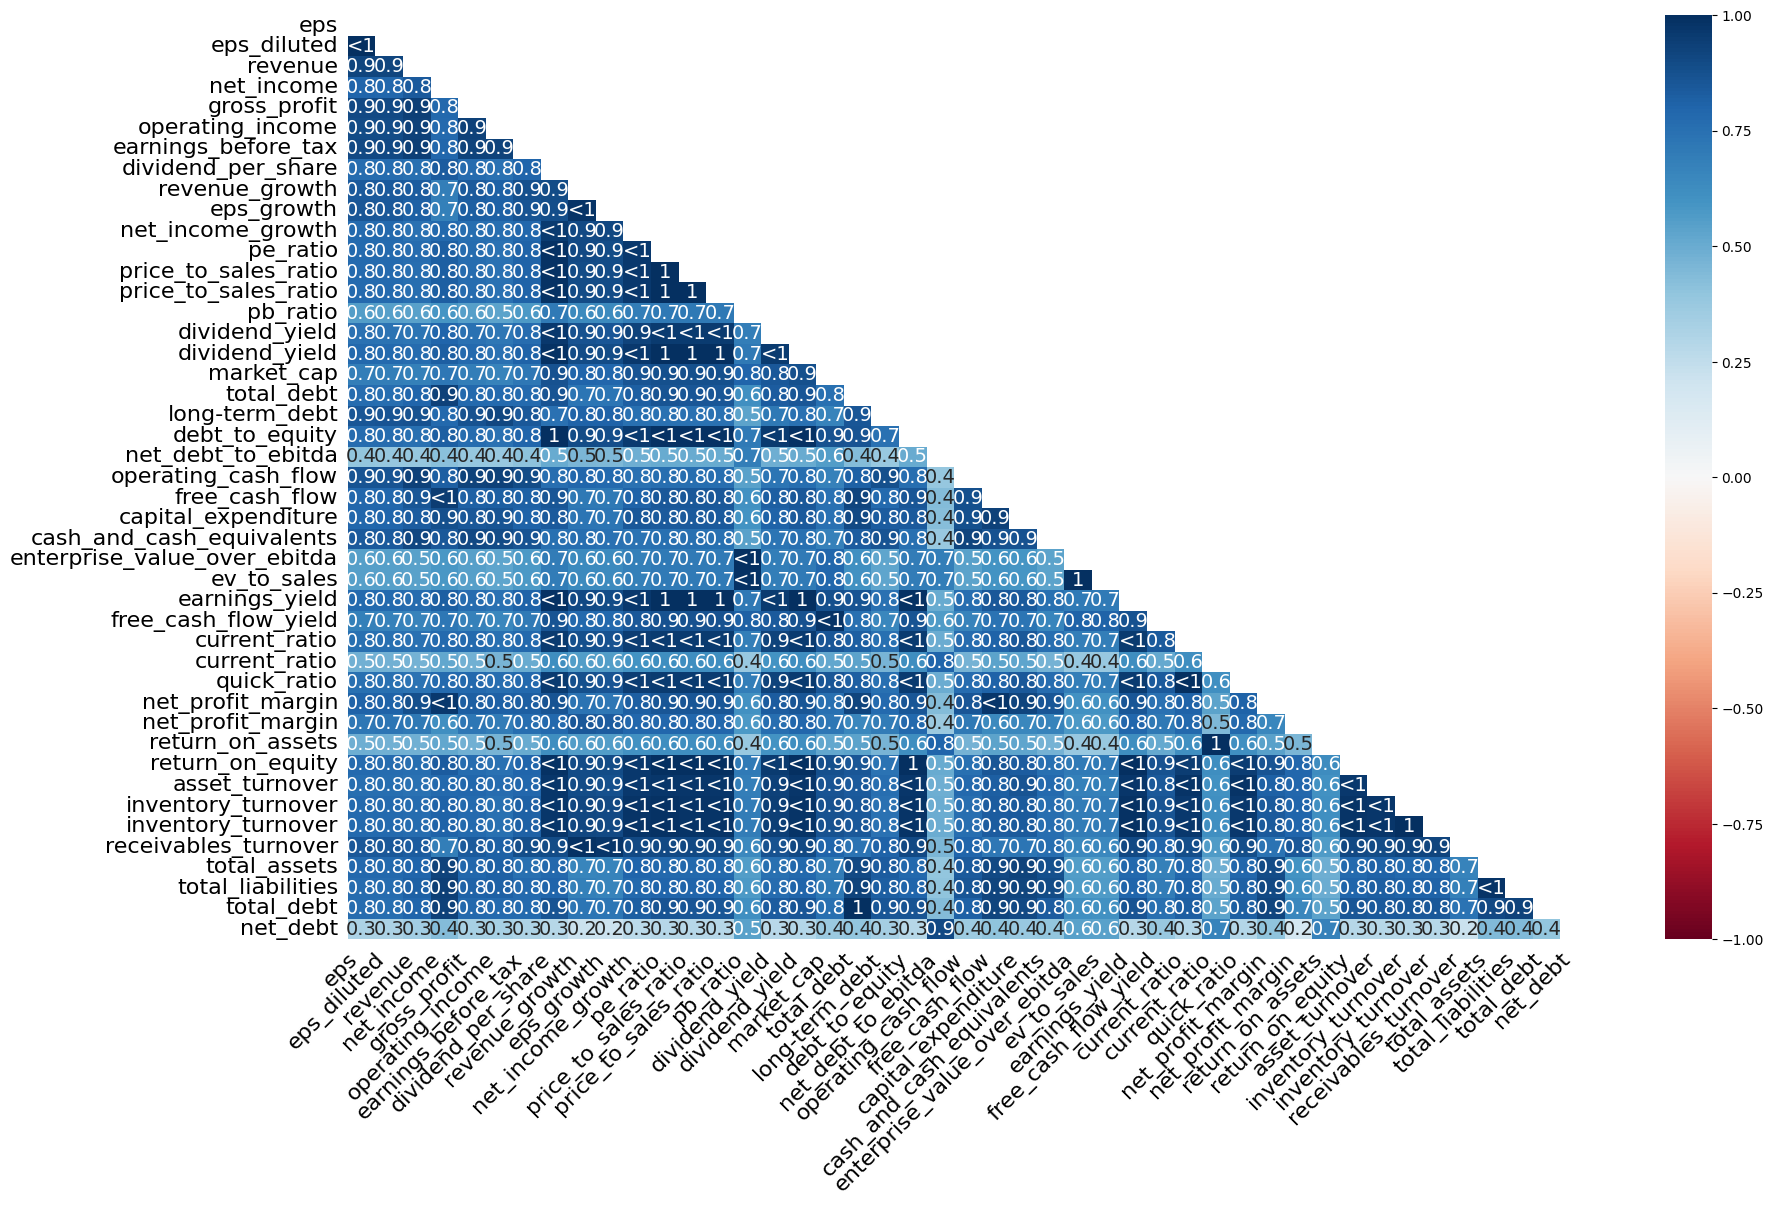

In [64]:
msno.heatmap(predictors2017_selected)

<Axes: >

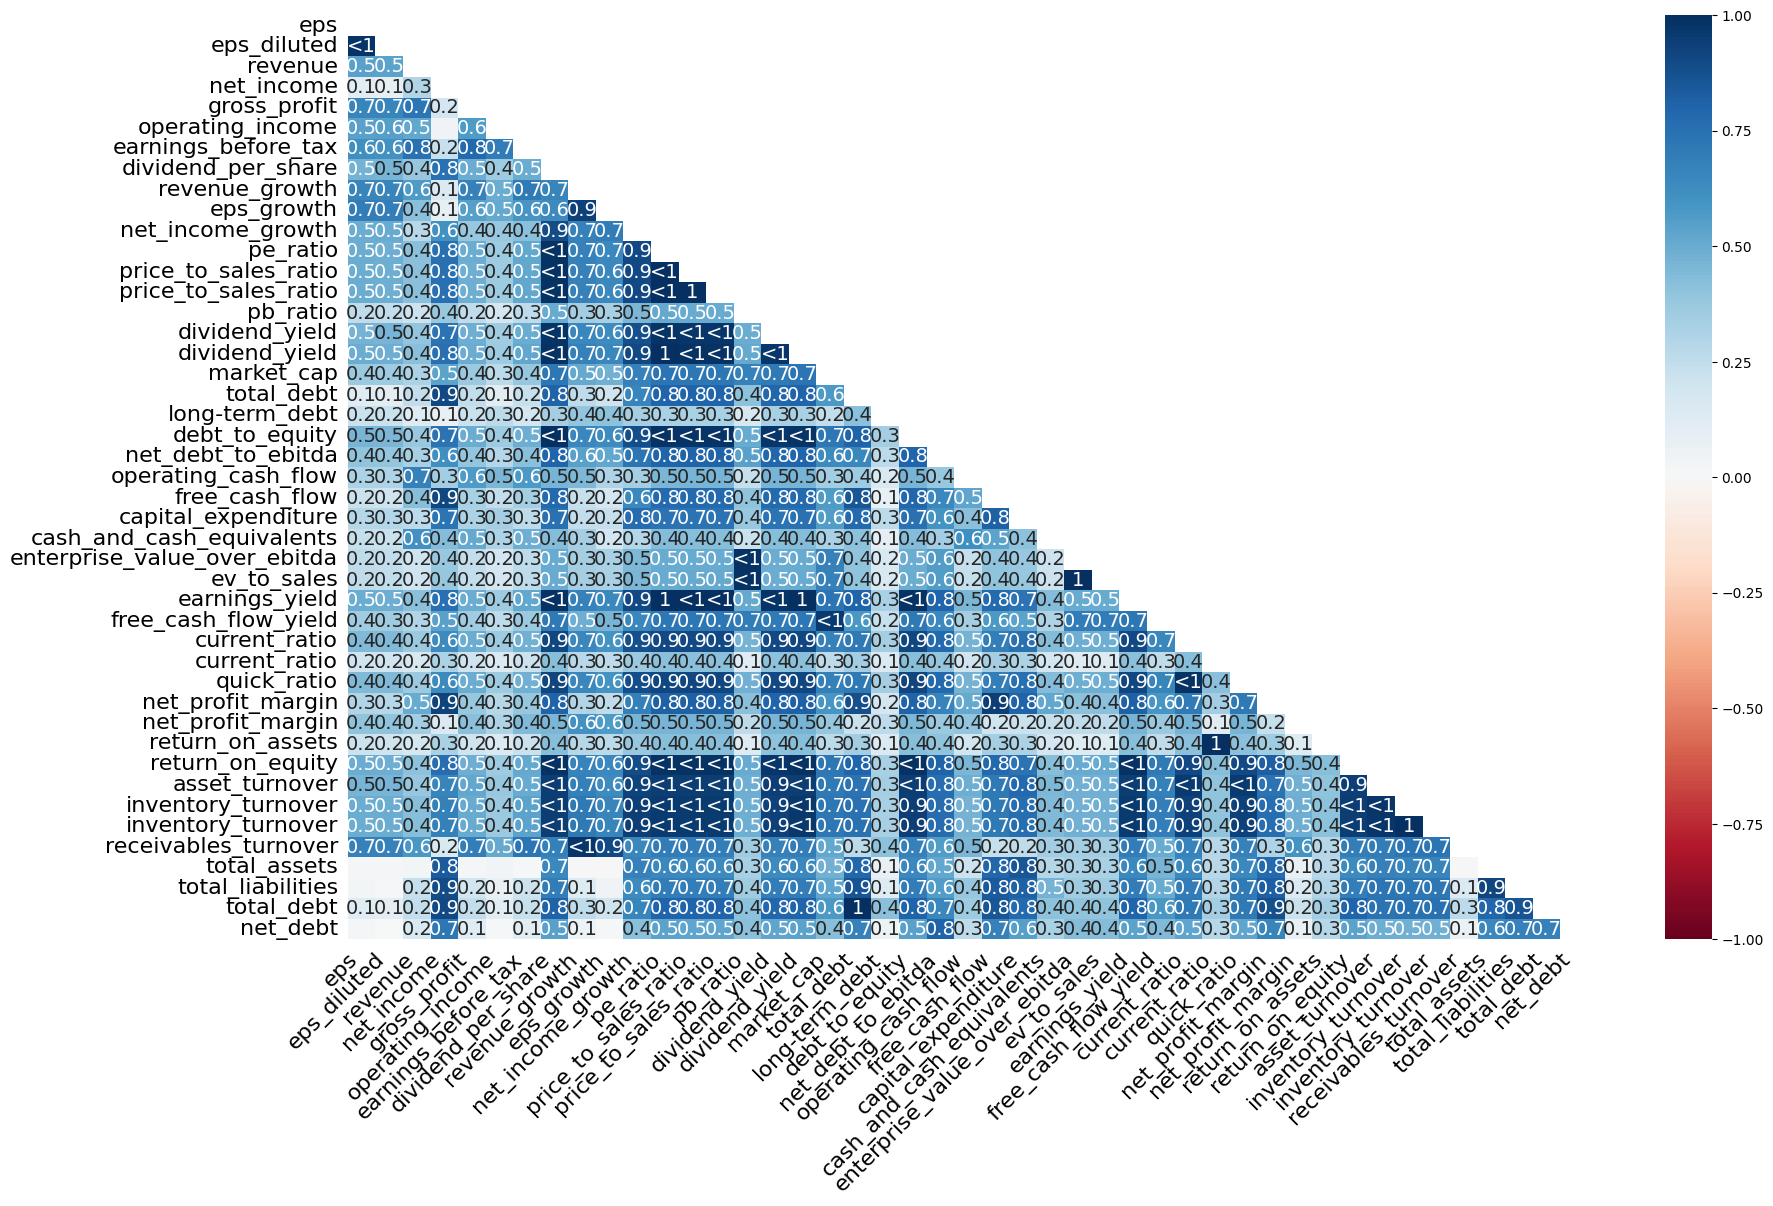

In [65]:
msno.heatmap(predictors2018_selected)

# Imbalance Issues

In [90]:
predictors2014.describe()

revenue  revenue_growth  cost_of_revenue  gross_profit  \
count  3.764000e+03     3572.000000     3.734000e+03  3.756000e+03   
mean   5.879050e+09       12.954244     3.700973e+09  2.188214e+09   
std    3.901741e+10      705.605473     3.040688e+10  1.159028e+10   
min   -6.276160e+08       -1.773200    -5.455740e+08 -1.105000e+09   
25%    5.788880e+07       -0.002350     3.135714e+06  3.092900e+07   
50%    4.349010e+08        0.061850     1.414420e+08  1.908760e+08   
75%    2.393625e+09        0.188875     1.199844e+09  8.922534e+08   
max    1.824698e+12    42138.663900     1.537249e+12  4.621600e+11   

       r&d_expenses  sg&a_expense  operating_expenses  operating_income  \
count  3.672000e+03  3.749000e+03        3.745000e+03      3.753000e+03   
mean   9.401830e+07  9.307406e+08        1.438144e+09      6.748248e+08   
std    6.408912e+08  4.820928e+09        7.305171e+09      3.786291e+09   
min   -1.500000e+05  0.000000e+00       -1.088448e+09     -6.786000e+09   
25%    0.000000e+00  1.548900e+07        3.106600e+07     -1.308000e+06   
50%    0.000000e+00  7.381800e+07        1.386610e+08      4.104400e+07   
75%    9.911000e+06  3.510000e+08        5.885100e+08      2.712980e+08   
max    1.153700e+10  1.856830e+11        3.056050e+11      1.565540e+11   

       interest_expense  earnings_before_tax  income_tax_expense  \
count      3.745000e+03         3.728000e+03        3.742000e+03   
mean       1.002018e+08         5.725866e+08        1.762750e+08   
std        6.991091e+08         2.793740e+09        1.011342e+09   
min       -2.250000e+08        -8.878000e+09       -2.081114e+09   
25%        0.000000e+00        -3.732902e+06        0.000000e+00   
50%        2.563000e+06         2.842700e+07        5.335000e+06   
75%        4.300000e+07         2.193835e+08        5.752550e+07   
max        3.152300e+10         8.720500e+10        3.970800e+10   

       net_income_-_non-controlling_int  net_income_-_discontinued_ops  \
count                      3.659000e+03                   3.659000e+03   
mean                       1.557750e+07                  -3.453915e+06   
std                        1.620427e+08                   2.360399e+08   
min                       -1.587227e+09                  -7.015198e+09   
25%                        0.000000e+00                   0.000000e+00   
50%                        0.000000e+00                   0.000000e+00   
75%                        0.000000e+00                   0.000000e+00   
max                        4.917409e+09                   8.368000e+09   

         net_income  preferred_dividends  net_income_com           eps  \
count  3.785000e+03         3.659000e+03    3.793000e+03  3.736000e+03   
mean   4.894335e+08         5.343177e+06    4.839166e+08 -2.607365e+04   
std    4.396692e+09         6.760107e+07    4.392279e+09  1.672636e+06   
min   -8.360000e+09        -1.262800e+07   -8.360000e+09 -1.018709e+08   
25%   -3.693000e+06         0.000000e+00   -4.369000e+06 -2.300000e-01   
50%    2.223100e+07         0.000000e+00    2.101400e+07  7.700000e-01   
75%    1.658440e+08         0.000000e+00    1.630900e+08  2.030000e+00   
max    2.339970e+11         2.741588e+09    2.339970e+11  8.028004e+06   

        eps_diluted  weighted_average_shs_out  weighted_average_shs_out_(dil)  \
count  3.724000e+03              3.572000e+03                    3.698000e+03   
mean  -2.653476e+04              2.865321e+08                    2.904988e+08   
std    1.673673e+06              2.304823e+09                    2.403028e+09   
min   -1.018709e+08              0.000000e+00                    0.000000e+00   
25%   -2.400000e-01              1.554453e+07                    1.379943e+07   
50%    7.500000e-01              4.268193e+07                    3.976000e+07   
75%    2.000000e+00              1.171910e+08                    1.130076e+08   
max    6.624003e+06              1.112919e+11                    1.112919e+11   

       dividend_per_share  g

In [91]:
predictors2015.describe()

revenue  revenue_growth  cost_of_revenue  gross_profit  \
count  4.053000e+03     3780.000000     3.927000e+03  4.055000e+03   
mean   5.005532e+09        0.289257     3.194520e+09  1.884870e+09   
std    3.455765e+10        3.579223     2.837197e+10  8.398565e+09   
min   -3.357020e+08       -1.064300    -2.665346e+09 -1.280800e+10   
25%    5.867900e+07       -0.051950     2.840826e+06  2.792500e+07   
50%    4.083450e+08        0.031850     1.448460e+08  1.783760e+08   
75%    2.219136e+09        0.160325     1.153572e+09  8.336660e+08   
max    1.886894e+12      189.817900     1.581527e+12  3.053670e+11   

       r&d_expenses  sg&a_expense  operating_expenses  operating_income  \
count  3.855000e+03  3.950000e+03        3.946000e+03      4.078000e+03   
mean   9.605866e+07  8.390737e+08        1.358340e+09      5.072675e+08   
std    6.755995e+08  3.487307e+09        5.194782e+09      2.774280e+09   
min   -4.179153e+06  0.000000e+00       -5.495512e+09     -1.933900e+10   
25%    0.000000e+00  1.713775e+07        3.410525e+07     -5.739400e+06   
50%    0.000000e+00  7.564400e+07        1.474340e+08      3.108000e+07   
75%    1.121000e+07  3.540000e+08        6.214052e+08      2.336181e+08   
max    1.306700e+10  9.341800e+10        9.341800e+10      7.123000e+10   

       interest_expense  earnings_before_tax  income_tax_expense  \
count      3.945000e+03         4.017000e+03        3.969000e+03   
mean       9.448146e+07         4.072179e+08       -6.935557e+07   
std        5.302102e+08         2.427021e+09        1.173891e+10   
min       -1.710954e+09        -1.910900e+10       -7.380000e+11   
25%        0.000000e+00        -1.058800e+07        0.000000e+00   
50%        2.844000e+06         1.952500e+07        3.858000e+06   
75%        4.460000e+07         1.721000e+08        4.470200e+07   
max        1.844600e+10         7.251500e+10        1.912100e+10   

       net_income_-_non-controlling_int  net_income_-_discontinued_ops  \
count                      3.833000e+03                   3.833000e+03   
mean                       1.205551e+07                  -5.747318e+06   
std                        1.352134e+08                   2.765625e+08   
min                       -1.500000e+09                  -1.076600e+10   
25%                        0.000000e+00                   0.000000e+00   
50%                        0.000000e+00                   0.000000e+00   
75%                        0.000000e+00                   0.000000e+00   
max                        4.786550e+09                   7.495000e+09   

         net_income  preferred_dividends  net_income_com           eps  \
count  3.955000e+03         3.833000e+03    4.001000e+03  4.024000e+03   
mean   3.258953e+08         4.079439e+06    3.221031e+08 -2.339272e+04   
std    2.294821e+09         4.412738e+07    2.280282e+09  1.213270e+06   
min   -1.456700e+10        -2.400000e+07   -1.473800e+10 -7.534036e+07   
25%   -1.026554e+07         0.000000e+00   -1.115700e+07 -5.000000e-01   
50%    1.539500e+07         0.000000e+00    1.473500e+07  5.900000e-01   
75%    1.367630e+08         0.000000e+00    1.350640e+08  1.850000e+00   
max    8.654900e+10         1.483000e+09    8.654900e+10  1.343348e+03   

        eps_diluted  weighted_average_shs_out  weighted_average_shs_out_(dil)  \
count  4.030000e+03              4.003000e+03                    3.870000e+03   
mean  -2.335794e+04              2.590582e+08                    2.658988e+08   
std    1.212367e+06              2.076529e+09                    2.234825e+09   
min   -7.534036e+07              0.000000e+00                    0.000000e+00   
25%   -5.000000e-01              1.635573e+07                    1.496340e+07   
50%    5.800000e-01              4.191980e+07                    4.026977e+07   
75%    1.820000e+00              1.123737e+08                    1.120585e+08   
max    1.343348e+03              1.053903e+11                    1.053903e+11   

       dividend_per_share  g

In [93]:
predictors2016.describe()

revenue  revenue_growth  cost_of_revenue  gross_profit  \
count  4.308000e+03     4148.000000     4.157000e+03  4.305000e+03   
mean   4.802586e+09        1.520193     3.060024e+09  1.824267e+09   
std    3.261058e+10       52.397806     2.705305e+10  7.913180e+09   
min   -3.819270e+08      -12.769300    -2.639031e+09 -3.564190e+09   
25%    5.212225e+07       -0.047275     2.699000e+06  2.659882e+07   
50%    4.059750e+08        0.032300     1.422140e+08  1.764620e+08   
75%    2.056847e+09        0.160525     1.106300e+09  8.003870e+08   
max    1.822805e+12     3234.456800     1.548384e+12  2.744210e+11   

       r&d_expenses  sg&a_expense  operating_expenses  operating_income  \
count  4.084000e+03  4.184000e+03        4.177000e+03      4.332000e+03   
mean   1.007484e+08  8.308651e+08        1.287227e+09      5.239260e+08   
std    7.347024e+08  3.465465e+09        4.930970e+09      2.548440e+09   
min   -8.610000e+07 -5.207792e+07       -9.357000e+08     -6.770000e+09   
25%    0.000000e+00  1.696775e+07        3.431300e+07     -5.629444e+06   
50%    0.000000e+00  7.584050e+07        1.509050e+08      3.043300e+07   
75%    1.237750e+07  3.505530e+08        5.941360e+08      2.242548e+08   
max    1.608500e+10  9.704100e+10        9.704100e+10      6.002400e+10   

       interest_expense  earnings_before_tax  income_tax_expense  \
count      4.177000e+03         4.266000e+03        4.201000e+03   
mean       9.451615e+07         4.309792e+08        8.904592e+07   
std        4.355067e+08         2.190013e+09        2.207093e+09   
min       -1.107000e+09        -7.621000e+09       -1.300000e+11   
25%        0.000000e+00        -9.890840e+06        0.000000e+00   
50%        3.275789e+06         1.993900e+07        3.768000e+06   
75%        4.717500e+07         1.655055e+08        4.251300e+07   
max        1.517600e+10         6.137200e+10        2.306200e+10   

       net_income_-_non-controlling_int  net_income_-_discontinued_ops  \
count                      4.059000e+03                   4.059000e+03   
mean                       1.106268e+07                  -3.942755e+06   
std                        1.386278e+08                   3.077208e+08   
min                       -1.487654e+09                  -1.591450e+10   
25%                        0.000000e+00                   0.000000e+00   
50%                        0.000000e+00                   0.000000e+00   
75%                        0.000000e+00                   0.000000e+00   
max                        6.430814e+09                   6.728000e+09   

         net_income  preferred_dividends  net_income_com           eps  \
count  4.191000e+03         4.059000e+03    4.239000e+03  4.275000e+03   
mean   3.095961e+08         4.910822e+06    3.127112e+08 -5.501432e+03   
std    1.683678e+09         5.914561e+07    1.708082e+09  2.550796e+05   
min   -2.155600e+10        -1.610000e+08   -2.155600e+10 -1.373438e+07   
25%   -1.111300e+07         0.000000e+00   -1.150975e+07 -4.600000e-01   
50%    1.466400e+07         0.000000e+00    1.436700e+07  5.500000e-01   
75%    1.320360e+08         0.000000e+00    1.332000e+08  1.860000e+00   
max    4.568700e+10         2.095062e+09    4.568700e+10  1.684010e+05   

        eps_diluted  weighted_average_shs_out  weighted_average_shs_out_(dil)  \
count  4.282000e+03              4.270000e+03                    4.107000e+03   
mean  -5.531801e+03              2.440547e+08                    2.525574e+08   
std    2.548572e+05              1.779103e+09                    1.953756e+09   
min   -1.373438e+07              1.000000e+00                    1.000000e+00   
25%   -4.600000e-01              1.680877e+07                    1.561430e+07   
50%    5.400000e-01              4.237932e+07                    4.124847e+07   
75%    1.820000e+00              1.132504e+08                    1.133235e+08   
max    1.510156e+03              8.821563e+10                    8.821563e+10   

       dividend_per_share  g

In [94]:
predictors2017.describe()

revenue  revenue_growth  cost_of_revenue  gross_profit  \
count  4.435000e+03     4236.000000     4.281000e+03  4.426000e+03   
mean   5.085608e+09        0.953124     3.235881e+09  1.934378e+09   
std    3.148389e+10       18.956861     2.619288e+10  7.911822e+09   
min   -3.004500e+07       -6.872700    -2.986888e+09 -8.138230e+08   
25%    5.900000e+07        0.000000     3.945000e+06  3.200000e+07   
50%    4.400000e+08        0.073050     1.588160e+08  1.993761e+08   
75%    2.254111e+09        0.211625     1.170103e+09  8.823762e+08   
max    1.695864e+12      825.959800     1.465577e+12  2.302870e+11   

       r&d_expenses  sg&a_expense  operating_expenses  operating_income  \
count  4.173000e+03  4.299000e+03        4.299000e+03      4.456000e+03   
mean   1.061590e+08  8.532075e+08        1.331302e+09      5.943889e+08   
std    7.983065e+08  3.521939e+09        5.214527e+09      2.763764e+09   
min   -1.098000e+08 -1.043667e+08       -1.088000e+09     -1.868300e+10   
25%    0.000000e+00  1.861650e+07        3.700850e+07     -4.376053e+06   
50%    0.000000e+00  8.360500e+07        1.638000e+08      3.739450e+07   
75%    1.400000e+07  3.711330e+08        6.229360e+08      2.604446e+08   
max    2.262000e+10  1.018530e+11        1.018530e+11      6.513565e+10   

       interest_expense  earnings_before_tax  income_tax_expense  \
count      4.283000e+03         4.381000e+03        4.325000e+03   
mean       9.961462e+07         4.974142e+08        3.197688e+08   
std        4.185841e+08         2.362747e+09        1.294980e+10   
min       -1.932443e+08        -1.819800e+10       -1.470800e+10   
25%        0.000000e+00        -9.396000e+06        0.000000e+00   
50%        4.800000e+06         2.464000e+07        1.968428e+06   
75%        5.300000e+07         1.976460e+08        4.201800e+07   
max        1.340100e+10         6.408900e+10        8.490000e+11   

       net_income_-_non-controlling_int  net_income_-_discontinued_ops  \
count                      4.125000e+03                   4.125000e+03   
mean                       1.314621e+07                   1.758702e+06   
std                        1.277166e+08                   1.860514e+08   
min                       -1.389189e+09                  -5.217000e+09   
25%                        0.000000e+00                   0.000000e+00   
50%                        0.000000e+00                   0.000000e+00   
75%                        0.000000e+00                   0.000000e+00   
max                        3.890266e+09                   5.127341e+09   

         net_income  preferred_dividends  net_income_com           eps  \
count  4.340000e+03         4.125000e+03    4.378000e+03  4.414000e+03   
mean   3.770531e+08         4.477003e+06    3.749310e+08 -1.371788e+03   
std    2.058431e+09         4.704482e+07    2.037733e+09  8.241842e+04   
min   -2.304500e+10        -4.800000e+07   -2.304500e+10 -5.419062e+06   
25%   -9.532250e+06         0.000000e+00   -9.979750e+06 -3.800000e-01   
50%    1.900000e+07         0.000000e+00    1.869100e+07  6.185000e-01   
75%    1.616768e+08         0.000000e+00    1.600448e+08  2.090000e+00   
max    5.065541e+10         1.629000e+09    5.065541e+10  1.444920e+05   

        eps_diluted  weighted_average_shs_out  weighted_average_shs_out_(dil)  \
count  4.420000e+03              4.412000e+03                    4.273000e+03   
mean  -1.402661e+03              2.629081e+08                    2.607630e+08   
std    8.233323e+04              2.058181e+09                    2.066946e+09   
min   -5.419062e+06              2.000000e+00                    2.000000e+00   
25%   -3.800000e-01              1.799960e+07                    1.715012e+07   
50%    6.100000e-01              4.454072e+07                    4.373414e+07   
75%    2.061500e+00              1.179750e+08                    1.170000e+08   
max    2.670000e+03              9.656035e+10                    9.656035e+10   

       dividend_per_share  g

In [95]:
predictors2018.describe()

revenue  revenue_growth  cost_of_revenue  gross_profit  \
count  4.346000e+03     4253.000000     4.207000e+03  4.328000e+03   
mean   5.119287e+09        3.455278     3.144946e+09  2.043954e+09   
std    2.049504e+10      195.504906     1.508813e+10  7.682369e+09   
min   -6.894100e+07       -3.461500    -2.669055e+09 -1.818220e+09   
25%    6.501425e+07        0.000000     3.415500e+06  3.618903e+07   
50%    4.982640e+08        0.074900     1.741180e+08  2.219470e+08   
75%    2.457878e+09        0.188500     1.297814e+09  9.767015e+08   
max    5.003430e+11    12739.000000     3.733960e+11  1.269470e+11   

       r&d_expenses  sg&a_expense  operating_expenses  operating_income  \
count  4.155000e+03  4.226000e+03        4.208000e+03      4.357000e+03   
mean   1.180176e+08  9.005022e+08        1.435546e+09      6.541207e+08   
std    9.330891e+08  3.661116e+09        5.529831e+09      2.969341e+09   
min   -1.042000e+08 -1.401594e+08       -4.280000e+09     -1.455700e+10   
25%    0.000000e+00  2.056226e+07        4.223644e+07     -5.510000e+06   
50%    0.000000e+00  9.390450e+07        1.806253e+08      4.203800e+07   
75%    1.450150e+07  4.117162e+08        6.796040e+08      2.862690e+08   
max    2.883700e+10  1.065100e+11        1.065100e+11      7.089800e+10   

       interest_expense  earnings_before_tax  income_tax_expense  \
count      4.208000e+03         4.321000e+03        4.252000e+03   
mean       1.001350e+08         5.584432e+08        1.228084e+08   
std        3.780021e+08         2.639327e+09        7.349214e+08   
min       -1.408252e+09        -2.177200e+10       -8.084000e+09   
25%        0.000000e+00        -1.000800e+07        0.000000e+00   
50%        5.693500e+06         2.730700e+07        2.720500e+06   
75%        5.817075e+07         2.238810e+08        4.034250e+07   
max        9.168000e+09         7.290300e+10        1.990300e+10   

       net_income_-_non-controlling_int  net_income_-_discontinued_ops  \
count                      4.142000e+03                   4.142000e+03   
mean                       1.521629e+07                  -5.021774e+06   
std                        1.539106e+08                   1.847068e+08   
min                       -1.241117e+09                  -8.345886e+09   
25%                        0.000000e+00                   0.000000e+00   
50%                        0.000000e+00                   0.000000e+00   
75%                        0.000000e+00                   0.000000e+00   
max                        6.073227e+09                   2.921000e+09   

         net_income  preferred_dividends  net_income_com            eps  \
count  4.241000e+03         4.142000e+03    4.275000e+03    4327.000000   
mean   4.473248e+08         4.596726e+06    4.483776e+08     -69.937477   
std    2.118659e+09         4.601394e+07    2.103791e+09    5718.694086   
min   -2.235500e+10        -3.833000e+07   -2.280200e+10 -359825.000000   
25%   -1.065152e+07         0.000000e+00   -1.108050e+07      -0.390000   
50%    2.365300e+07         0.000000e+00    2.335100e+07       0.690000   
75%    1.962100e+08         0.000000e+00    1.971180e+08       2.310000   
max    5.953100e+10         1.704000e+09    5.953100e+10  101641.000000   

         eps_diluted  weighted_average_shs_out  \
count    4329.000000              4.326000e+03   
mean      -71.428788              2.668513e+08   
std      5691.798912              2.025499e+09   
min   -359825.000000              1.190000e+02   
25%        -0.390000              1.954417e+07   
50%         0.680000              4.714435e+07   
75%         2.280000              1.253193e+08   
max     95231.443300              9.133623e+10   

       weighted_average_shs_out_(dil)  dividend_per_share  gross_margin  \
count                    4.192000e+03         4142.000000   4341.000000   
mean                     2.653567e+08            0.612978      0.497372   
std                      2.034455e+09            1.452642      0.583199  

# Data Scaling